<a href="https://colab.research.google.com/github/pachterlab/CP_2022/blob/main/notebooks/suppCellRankAnalysis/allInterIntraDistortions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Mon Nov 15 17:16:26 UTC 2021


In [1]:
import requests
import os


In [2]:
#Download datasets




from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname



#SMART-seq VMH data
#metadata.csv
download_file('10.22002/D1.2067','.gz')

#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')



#MERFISH data
#metadata.csv
download_file('10.22002/D1.2063','.gz')

#counts.h5ad
download_file('10.22002/D1.2064','.gz')

#10x VMH data
#metadata.csv
download_file('10.22002/D1.2065','.gz')

#tenx.mtx (log counts)
download_file('10.22002/D1.2072','.gz')



os.system("gunzip *.gz")



os.system("mv D1.2067 smartmetadata.csv")
os.system("mv D1.2071 smartseq.mtx")

os.system("mv D1.2063 metadata.csv")
os.system("mv D1.2064 counts.h5ad")

os.system("mv D1.2065 tenxmetadata.csv")
os.system("mv D1.2072 tenx.mtx")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/64 [00:00<?, ?B/s]

  0%|          | 0/26700 [00:00<?, ?B/s]

  0%|          | 0/9784 [00:00<?, ?B/s]

  0%|          | 0/59360 [00:00<?, ?B/s]

  0%|          | 0/940 [00:00<?, ?B/s]

  0%|          | 0/104912 [00:00<?, ?B/s]

0

In [3]:
#Read in files from NCBI GEO
os.system("wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz")
os.system("wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz")

0

In [4]:
os.system("git clone https://github.com/hhcho/densvis.git")

0

In [5]:
%cd ./densvis/densne/


!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

/content/densvis/densne
densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient acc

In [6]:
%cd ../../

/content


In [7]:
!gunzip *.gz

In [8]:
!git clone https://github.com/pachterlab/CP_2022.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 609, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 609 (delta 101), reused 54 (delta 21), pack-reused 424
Receiving objects: 100% (609/609), 195.29 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (314/314), done.
Checking out files: 100% (76/76), done.


In [9]:
%cd ./CP_2022/scripts

/content/CP_2022/scripts


In [10]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0 #1.7.0rc1
!pip3 install --quiet umap-learn

     |████████████████████████████████| 96 kB 175 kB/s 
     |████████████████████████████████| 7.7 MB 3.8 MB/s 
     |████████████████████████████████| 88 kB 6.5 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


## **Install Packages**

In [39]:
import networkx as nx
import anndata 
import pandas as pd
import numpy as np

import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
import matplotlib.patches as patches
import itertools
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')

In [12]:
sc.set_figure_params(dpi=125)

In [ ]:
import torchvision

mnist = torchvision.datasets.MNIST(root='.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
torch.manual_seed(0)

mnist_flattened = mnist.data.reshape((mnist.data.shape[0], -1))
n_images = 60000
indices = torch.randperm(mnist_flattened.shape[0])[:n_images]
data = mnist_flattened[indices].float()
digits = mnist.targets[indices]
batch_size = n_images // 10

In [ ]:
digits

tensor([9, 3, 5,  ..., 4, 9, 1])

In [ ]:
data.shape

torch.Size([60000, 784])

## **Plot Distributions of Ambient and Latent Inter/Intra-Type Distance**

In [13]:
#Setting metric
met = 'l1'

### **Analysis and Plotting functions**

In [14]:

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../..'

pcs = 50
pcs2 = 100
n_latent = 50


In [15]:
def latentComp(scaled_mat, log_mat, ndims=2, pcs=[50,100], rounds = 3):
  """ Compute latent space representations as baseline for reconstruction abilities"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  latents += [log_mat]
  latentLab += ['Ambient']
  latentType += ['Ambient']

  for i in range(rounds):

    for j in pcs:

      tsvd = TruncatedSVD(n_components=j)
      x_pca = tsvd.fit_transform(scaled_mat)
    
      pcaUMAP = reducer.fit_transform(x_pca)
      #pcaDensUMAP = densUMAP.fit_transform(x_pca)

      pcaTSNE = tsne.fit_transform(x_pca)

      latents += [x_pca,pcaTSNE, pcaUMAP]
      latentLab += ['PCA '+str(j)+'D','PCA '+str(j)+'D t-SNE','PCA '+str(j)+'D UMAP']
      latentType += [str(j)+'D','2D','2D']




  return latents,latentLab,latentType

In [16]:
def latentCompMNIST(scaled_mat,log_mat, ndims=2, pcs=[50,100], rounds = 3):
  """ Compute latent space representations as baseline for reconstruction abilities"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  latents += [log_mat]
  latentLab += ['Ambient']
  latentType += ['Ambient']


  for i in range(rounds):

    for j in pcs:

      tsvd = TruncatedSVD(n_components=j)
      x_pca = tsvd.fit_transform(scaled_mat)
    
      pcaUMAP = reducer.fit_transform(scaled_mat)
      #pcaDensUMAP = densUMAP.fit_transform(x_pca)

      pcaTSNE = tsne.fit_transform(scaled_mat)

      latents += [x_pca,pcaTSNE, pcaUMAP]
      latentLab += ['PCA '+str(j)+'D','t-SNE','UMAP']
      latentType += [str(j)+'D','2D','2D']

  tsvd = TruncatedSVD(n_components=2)
  x_pca = tsvd.fit_transform(scaled_mat)

  latents += [x_pca]
  latentLab += ['PCA 2D']
  latentType += ['2D']


  return latents,latentLab,latentType

In [17]:
def getInterVar2(embed, inLab):
  """ Compute inter-distances for inner label
  embed : Numpy array for latent space (n_obs x n_features or n_latent)
  inLab : 1D array for inner label (e.g. sex)
  Returns:
  List of average pairwise distances between labels in inLab"""


  avg_dists = []

  ins = np.unique(inLab)

  pairs = list(itertools.combinations(ins, 2))
  for p in pairs:

    sub_1 = embed[inLab == p[0],:]
    sub_2 = embed[inLab == p[1],:]
    avg_dists += [np.mean(pairwise_distances(sub_1,sub_2,metric=met).flatten().tolist())]

  return avg_dists

In [18]:
def getAllVars(latents,latentLab,latentType,clusters):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = getInterVar2(i, clusters)
    #c = [x for x in c if x != 0.0]
    vals += c
    emb += [l]*len(c)
    dist += ['Inter-Type']*len(c)

    intraC = tl.getIntraVar(i, clusters, clusters,m=met)
    vals += intraC
    dist += ['Intra-Type']*len(intraC)

    emb += [l]*len(intraC)



  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Value'] = vals



  return allVals

In [19]:
def rankClus(embed, inLab):
  """ Compute inter-distances for inner label
  embed : Numpy array for latent space (n_obs x n_features or n_latent)
  inLab : 1D array for inner label (e.g. sex)
  Returns:
  Dictionary with avg distances between labeled groups, for each label"""


  avg_dists = []
  

  ins = np.unique(inLab)
  d = np.zeros((len(ins),len(ins)))

  for i in range(len(ins)):

    avg_dists = []
    for j in ins:

      sub_1 = embed[inLab == ins[i],:]
      sub_2 = embed[inLab == j,:]
      avg_dists += [np.mean(pairwise_distances(sub_1,sub_2,metric=met).flatten().tolist())]
      
    d[i,:] = avg_dists



  return d

In [20]:
def intraVar(embed, inLab):
  """ Compute inter-distances for inner label
  embed : Numpy array for latent space (n_obs x n_features or n_latent)
  inLab : 1D array for inner label (e.g. sex)
  Returns:
  Dictionary with avg distances between labeled groups, for each label"""


  avg_dists = []
  

  ins = np.unique(inLab)


  for i in range(len(ins)):



    sub_1 = embed[inLab == ins[i],:]

    avg = pairwise_distances(sub_1,sub_1,metric=met).flatten().tolist()
    avg_dists += [np.mean([i for i in avg if i != 0])]
      




  return avg_dists

In [21]:
def getAllNeigh(latents,latentLab,latentType,clusters):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  amb = latents[0]
  cAmb = rankClus(amb, clusters)

  latents = latents[1:]
  latentLab = latentLab[1:]

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]


    c = rankClus(i, clusters)
    #c = [x for x in c if x != 0.0]

    for x in range(c.shape[0]):
      tau, p_value = stats.kendalltau(c[x,:], cAmb[x,:])
      vals += [tau]


    emb += [l]*c.shape[0]
 

  allVals['Latent'] = emb

  allVals['Tau'] = vals



  return allVals

In [22]:
def getIntra(latents,latentLab,latentType,clusters):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  amb = latents[0]
  cAmb = intraVar(amb, clusters)

  latents = latents[1:]
  latentLab = latentLab[1:]

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]


    c = intraVar(i, clusters)
    #c = [x for x in c if x != 0.0]


    v = stats.pearsonr(c, cAmb)
    vals += [v[0]]


    emb += [l]
 

  allVals['Latent'] = emb

  allVals['r'] = vals



  return allVals

Plotting

In [23]:
def plotHists(ax,allVals, x ,hue, xlab='',ylab='',title='', axisFontSize = 11, tickFontSize = 10):
  """ Plot histograms for inter/intra distances of nearest neighbors """

  #plt.figure(figsize=figsize)
  g=sns.histplot(data=allVals, x=x, hue=hue, kde=True,edgecolor="white",legend=True,ax=ax) #
  g.legend(handles=ax.legend_.legendHandles, labels=[t.get_text() for t in ax.legend_.texts],prop={"size":9})


  g.set_xlabel(xlab,fontsize=axisFontSize)
  g.set_ylabel(ylab,fontsize=axisFontSize)
  g.set_title(title,fontsize=axisFontSize)

  g.tick_params(labelsize=tickFontSize)

In [24]:
def plotAmb(allVals):
  rows = np.unique(allVals.Latent)
  fig, ax = plt.subplots(nrows=len(rows), ncols=1,figsize=(7,25),sharex=True)
  
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(len(rows)):
    #rowInds = [rows[i] == x for x in allVals['Latent']]
    sub = allVals[allVals['Latent'].isin([rows[i]])]


    if i == 0:
      ylab = 'Probability'
    else:
      ylab= ''

    if i == 6:
      xlab = 'Inter-/Intra-Type Distances'
    else:
      xlab = ''
    
    plotHists(ax[i],sub,'Value' ,'Distance',xlab=xlab,ylab=ylab,title=rows[i],axisFontSize = 9,tickFontSize = 8)
    print(list(sub['KS'])[0])



  #plt.xticks(fontsize=5)
  plt.show()

In [25]:
def plotDots(ax,allVals, x, y ,hue, size, xlab='',ylab='',title='', axisFontSize = 11, tickFontSize = 10):
  """ Plot histograms for inter/intra distances of nearest neighbors """

  #plt.figure(figsize=figsize)
  sns.boxplot(data=allVals, x=x, y=y, whis=np.inf,ax=ax,boxprops={'facecolor':'None'})
  g= sns.swarmplot(data=allVals, x=x, y=y, hue=hue, ax=ax,alpha=0.6,size=size) #
  labels=[t.get_text() for t in ax.legend_.texts]
  g.legend(handles=ax.legend_.legendHandles[3:6], labels=labels[3:6],prop={"size":9})

  g.grid(False)
  g.set_xlabel(xlab,fontsize=axisFontSize)
  g.set_ylabel(ylab,fontsize=axisFontSize)
  g.set_title(title,fontsize=axisFontSize)

  g.set_ylim(bottom=np.min([np.min(allVals[y]),0.0]), top=np.max([np.max(allVals[y]),1.0]))
  
  g.tick_params(labelsize=tickFontSize)

  g.spines['right'].set_visible(False)
  g.spines['top'].set_visible(False)

In [26]:
def plotDots2(ax,allVals, x, y ,hue, size, xlab='',ylab='',title='', axisFontSize = 11, tickFontSize = 10):
  """ Plot histograms for inter/intra distances of nearest neighbors """

  #plt.figure(figsize=figsize)
  sns.boxplot(data=allVals, x=x, y=y, whis=np.inf,ax=ax,boxprops={'facecolor':'None'})
  g= sns.swarmplot(data=allVals, x=x, y=y, hue=hue, ax=ax,alpha=0.6,size=size) #
  labels=[t.get_text() for t in ax.legend_.texts]
  g.legend(handles=ax.legend_.legendHandles, labels=labels,prop={"size":9})

  g.set_ylim(bottom=np.min([np.min(allVals[y]),0.0]), top=np.max([np.max(allVals[y]),1.0]))

  g.set_xlabel(xlab,fontsize=axisFontSize)
  g.set_ylabel(ylab,fontsize=axisFontSize)
  g.set_title(title,fontsize=axisFontSize)

  g.tick_params(labelsize=tickFontSize)

In [27]:
def plotNeigh(allVals,size=3.5,x='Latent',y='Tau',ylab="Kendall's Tau Correlation",hue='Latent'):
  rows = ['50D','100D']
  fig, ax = plt.subplots(nrows=len(rows), ncols=1,figsize=(5,7),dpi=300)
  
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(len(rows)):
    rowInds = [rows[i] in x for x in allVals[x]]
    sub = allVals[rowInds]


    if i == 0:
      ylab = ylab
    else:
      ylab= ''

    if i == 1:
      xlab = 'Embedding'
    else:
      xlab = ''
    
    plotDots(ax[i],sub,x ,y,hue=hue,xlab=xlab,ylab=ylab,axisFontSize = 9,tickFontSize = 8,size=size)
 



  #plt.xticks(fontsize=5)
  plt.show()

In [28]:
def plotNeighSingle(allVals,size=3.5,figsize=(5,7),hue='Latent'):
  
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)
  
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(1):
    #rowInds = [rows[i] in x for x in allVals['Latent']]
    sub = allVals.copy() #[rowInds]


    if i == 0:
      ylab = "Kendall's Tau Correlation"
    else:
      ylab= ''

    if i == 1:
      xlab = 'Embedding'
    else:
      xlab = ''
    
    plotDots(ax,sub,'Latent' ,'Tau',hue,xlab=xlab,ylab=ylab,axisFontSize = 9,tickFontSize = 8,size=size)
 



  #plt.xticks(fontsize=5)
  plt.show()

In [29]:
def plotNeighSingle2(allVals,size=3.5,figsize=(5,7),x='Latent',y='Tau',ylab="Kendall's Tau Correlation",hue='Latent'):
  
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)
  
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(1):
    #rowInds = [rows[i] in x for x in allVals['Latent']]
    sub = allVals.copy() #[rowInds]


    if i == 0:
      ylab = ylab
    else:
      ylab= ''

    if i == 1:
      xlab = 'Embedding'
    else:
      xlab = ''
    
    plotDots2(ax,sub,x ,y,hue,xlab=xlab,ylab=ylab,axisFontSize = 9,tickFontSize = 8,size=size)
 



  #plt.xticks(fontsize=5)
  plt.show()

In [30]:
#Paint correct digits on bottom and 'wrongly' clustered digits on top


#For each k-means clusters paint points in majority digit (from ground truth) first
def plotOnTop(latent,palette,labels,size=5):
  digs = digits.numpy()
  for d in np.unique(labels): #digits.numpy()

    inds = labels == d #
    kmeans = labels[inds]
    #origLabs.isin([d])
    sub_d = digs[inds]
    unique, counts = np.unique(sub_d, return_counts=True) #kmeans

    sub = latent[inds,:]
    #Get index of max counts
    clus = unique[np.argmax(counts)]
    cInds = sub_d ==  clus #kmeans == clus

    sub_d = sub_d[cInds]

    sub = sub[cInds,:]
    
    sns.scatterplot(sub[:,0],sub[:,1],hue=pd.Categorical(sub_d),palette=palette, alpha=0.5,size=size,legend=False)

  #For each cluster paint points in not the majority digit
  for d in np.unique(labels):
    inds = labels == d #origLabs.isin([d])
    kmeans = labels[inds]
    sub_d = digs[inds]
    unique, counts = np.unique(sub_d, return_counts=True)

    sub = latent[inds,:]
    #Get index of max counts
    clus = unique[np.argmax(counts)]
    cInds = sub_d != clus #kmeans == clus

    sub_d = sub_d[cInds]

    sub = sub[cInds,:]
    
    sns.scatterplot(sub[:,0],sub[:,1],hue=pd.Categorical(sub_d),palette=palette,alpha=0.5,size=size,legend=False)



  plt.grid(False)
  plt.show()


### **Test MNIST**

In [ ]:
#Get PCA, t-SNE, and UMAP embeddings

latents,latentLab,latentType = latentCompMNIST(data.numpy(), data.numpy(), ndims=2, pcs=[50], rounds = 1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
#Get digit rankings for all points in each digit (which other group/digits are they closest to or furthest from)
inds = [range(0,len(latents))]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],digits.cpu().detach().numpy())]

d50 = pd.concat(dfs)
d50.head()

Latent       Tau
0  PCA 50D  0.822222
1  PCA 50D  0.866667
2  PCA 50D  0.866667
3  PCA 50D  0.955556
4  PCA 50D  0.955556

In [ ]:
latentLab

['Ambient', 'PCA 50D', 't-SNE', 'UMAP', 'PCA 2D']

How well does k-means clustering do for identification?

In [ ]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=10, random_state=1).fit(latents[2])
labels = kmeans_model.labels_



kmeans_model_umap = KMeans(n_clusters=10, random_state=42).fit(latents[3])
labelsUMAP = kmeans_model_umap.labels_

In [ ]:

palette = {0:sns.color_palette()[0], 1:sns.color_palette()[1], 2:sns.color_palette()[2], 3:sns.color_palette()[3], 4:sns.color_palette()[4], 
           5:sns.color_palette()[5], 6:sns.color_palette()[6], 7:sns.color_palette()[7], 8:sns.color_palette()[8], 9:sns.color_palette()[9]}

In [ ]:
np.unique(digits.numpy())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


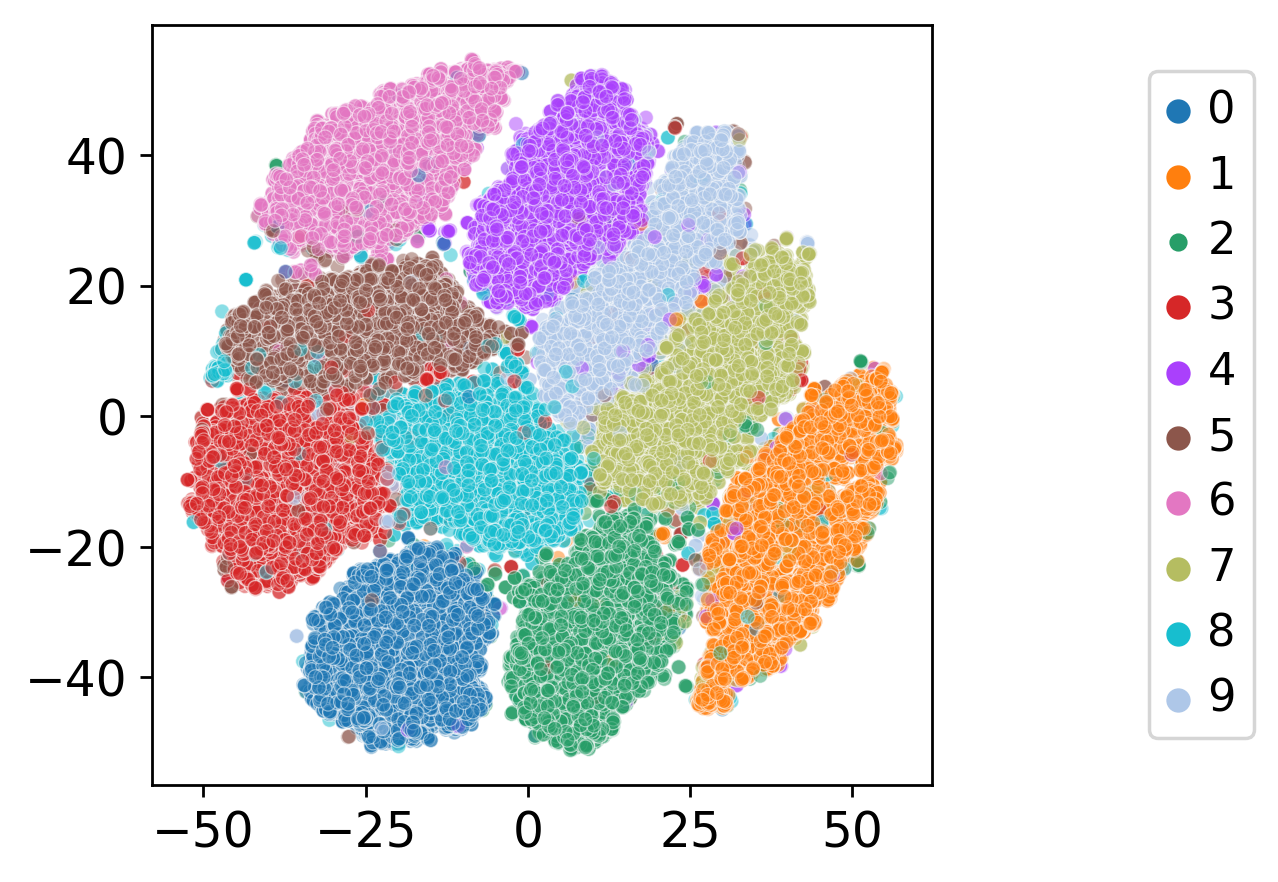

In [ ]:
#t-SNE
g=sns.scatterplot(latents[2][:,0],latents[2][:,1],hue=pd.Categorical(digits.numpy()),alpha=0.5,size=2)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.grid(False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


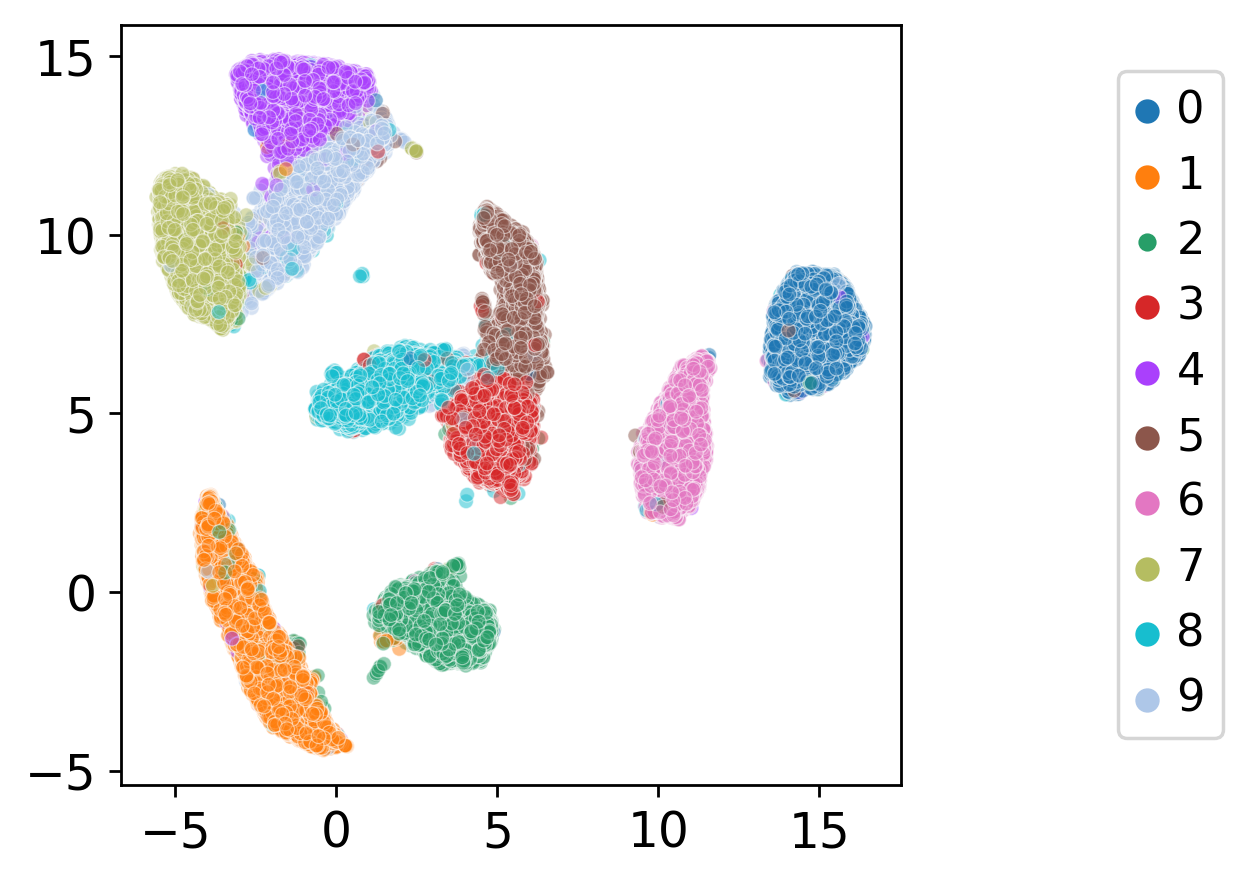

In [ ]:
#UMAP
g= sns.scatterplot(latents[3][:,0],latents[3][:,1],hue=pd.Categorical(digits.numpy()),alpha=0.5,size=2)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.grid(False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

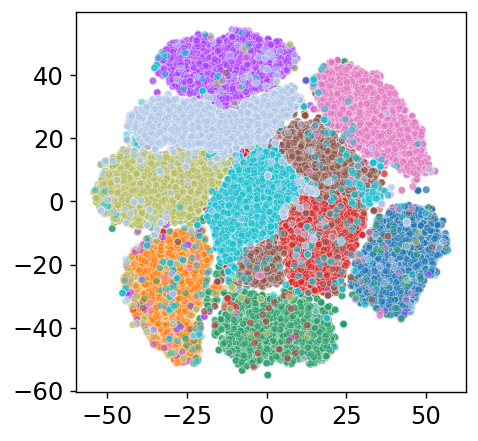

In [ ]:
plotOnTop(latents[2],palette,labels,size=2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

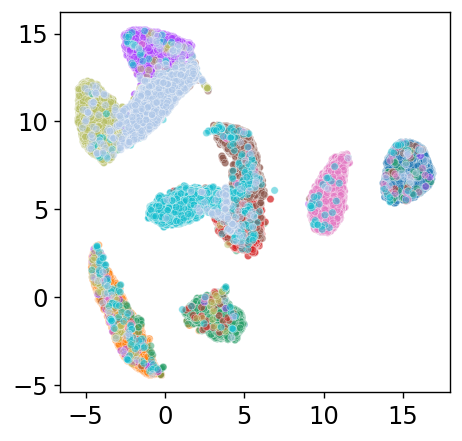

In [ ]:
plotOnTop(latents[3],palette,labelsUMAP,size=2)

In [ ]:
#How many of each digit were in the same cluster
#for each digit, get indices, find how many of those indices have the same value in labels
def getKMeans(labels):
  frac = []
  for d in np.unique(digits.numpy()):

    inds = digits.numpy() == d
    sub = labels[inds]

    unique, counts = np.unique(sub, return_counts=True)
    frac += [max(counts)/len(sub)]

  df = pd.DataFrame()
  df['Digit'] = np.unique(digits.numpy())
  df['Fraction'] = frac
  
  return df

In [ ]:
#t-SNE
df = getKMeans(labels)

print(np.mean(df.Fraction))
df

0.8484671366075048


Digit  Fraction
0      0  0.985143
1      1  0.797241
2      2  0.947801
3      3  0.931006
4      4  0.958576
5      5  0.930456
6      6  0.922609
7      7  0.606864
8      8  0.900017
9      9  0.504959

In [ ]:
#UMAP
dfUMAP = getKMeans(labelsUMAP)

print(np.mean(dfUMAP.Fraction))
dfUMAP

0.8915230916540594


Digit  Fraction
0      0  0.992402
1      1  0.543607
2      2  0.957872
3      3  0.968684
4      4  0.982369
5      5  0.913854
6      6  0.989692
7      7  0.972386
8      8  0.876260
9      9  0.718104

Large loss of internal information (relevant in biology but maybe less so for MNIST analysis)

In [ ]:
#Get intra-distances (internal variances of each digit) and corr to ambient

inds = [range(0,len(latents))]

dfs = []
for d in inds:
  dfs += [getIntra([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],digits.cpu().detach().numpy())]

dIntra = pd.concat(dfs)
dIntra.head()

Latent         r
0  PCA 50D  0.995601
1    t-SNE -0.808981
2     UMAP -0.781011
3   PCA 2D  0.894619

Plot distortion in digit rankings

In [ ]:
#PCA makes a lot of things close, and a few things distance

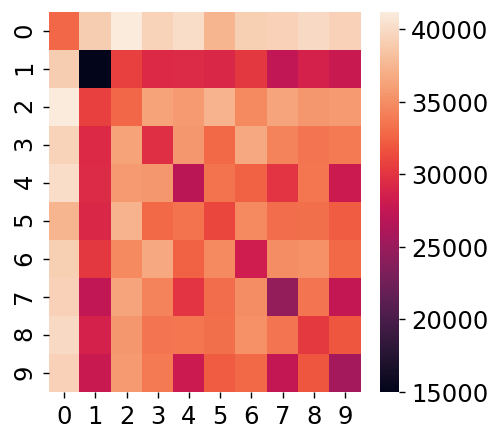

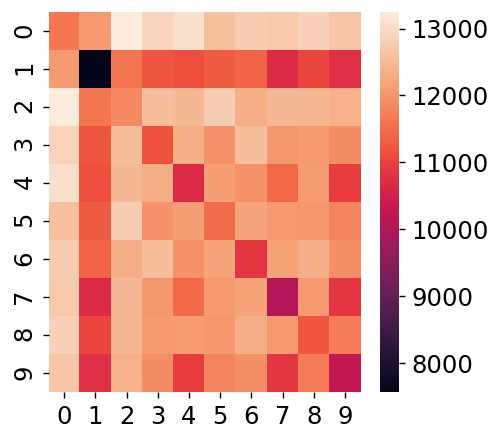

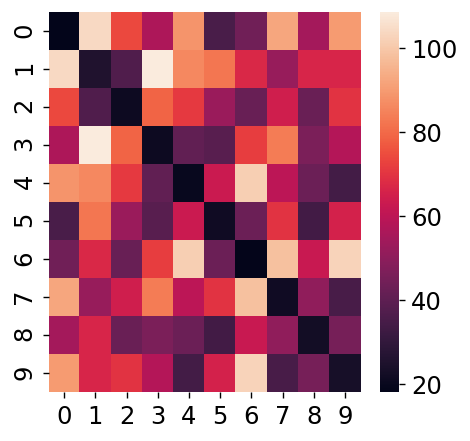

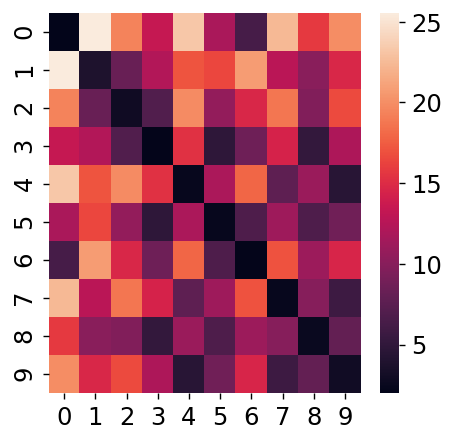

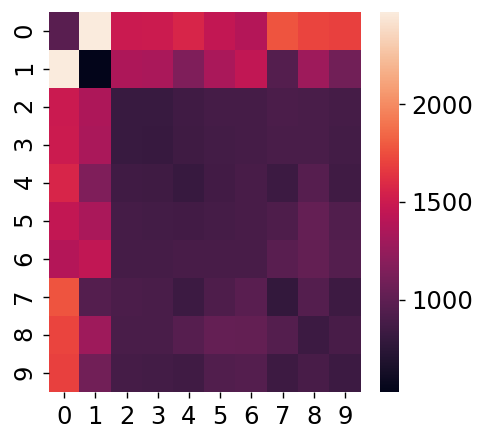

In [ ]:
#Plot heatmap of distances
c = []
for i in latents:
  r = rankClus(i, digits.cpu().detach().numpy())
  c += [r]
  sns.heatmap(r)
  plt.show()

In [ ]:
d50['Digit'] = np.unique(digits.numpy()).tolist()*4
d50.head()

Latent       Tau  Digit
0  PCA 50D  0.822222      0
1  PCA 50D  0.866667      1
2  PCA 50D  0.866667      2
3  PCA 50D  0.955556      3
4  PCA 50D  0.955556      4

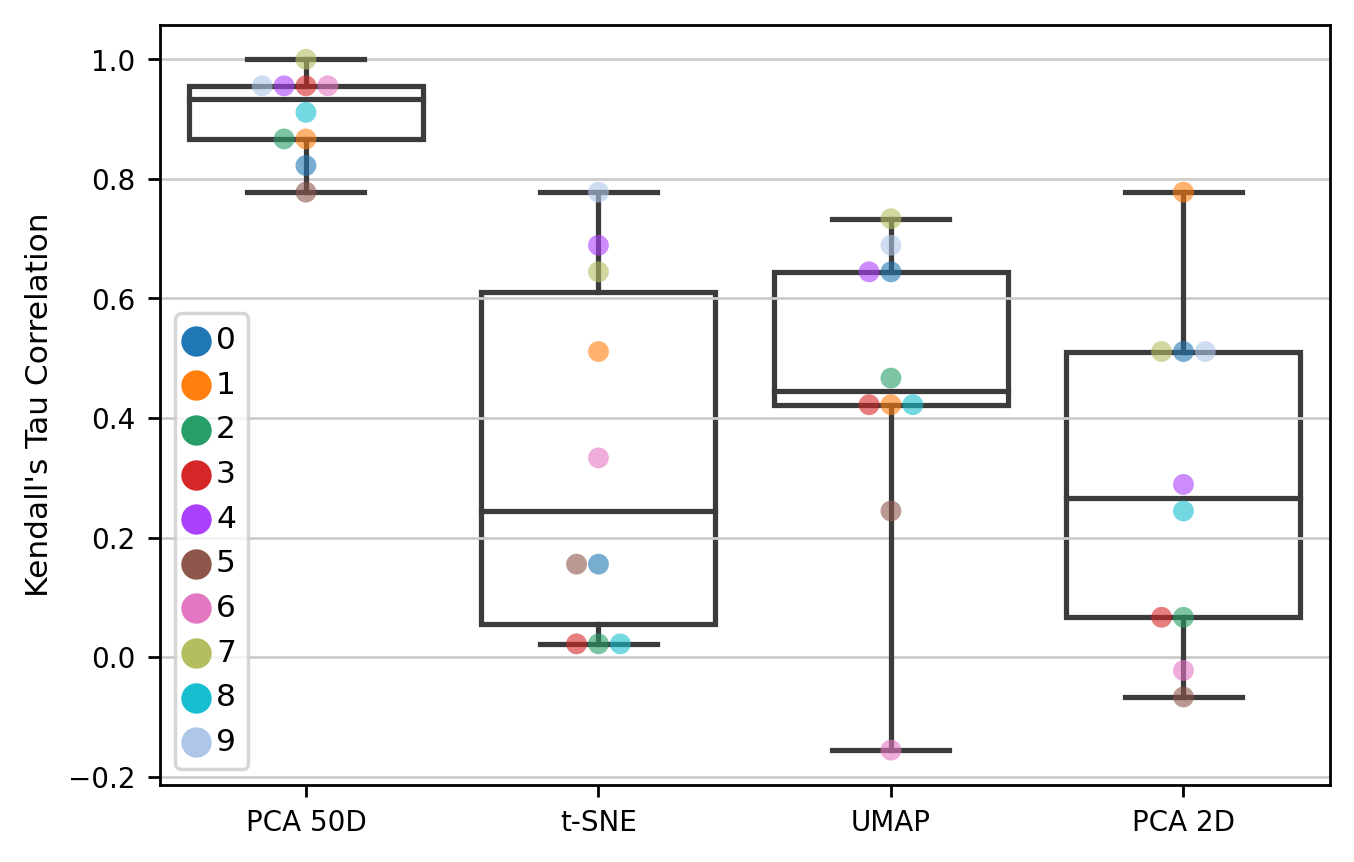

In [ ]:
plotNeighSingle2(d50[~d50['Latent'].isin(['Ambient'])],size=6,figsize=(6,4),hue='Digit')

In [ ]:
# inds = [[4,5,6]]#,[10,11,12],[16,17,18]]

# dfs = []
# for d in inds:
#   dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],meta.smartseq_cluster)]
# d100 = pd.concat(dfs)
# d100.head()

In [ ]:
# plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

See prediction accuracy

In [ ]:
def knn_infer(embd_space, labeled_idx, labeled_lab, unlabeled_idx,n_neighbors=15):
	"""
	Predicts the labels of unlabeled data in the embedded space with KNN.
	Parameters
	----------
	embd_space : ndarray (n_samples, embedding_dim)
		Each sample is described by the features in the embedded space.
		Contains all samples, both labeled and unlabeled.
	labeled_idx : list
		Indices of the labeled samples (used for training the classifier).
	labeled_lab : ndarray (n_labeled_samples)
		Labels of the labeled samples.
	unlabeled_idx : list
		Indices of the unlabeled samples.
	Returns
	-------
	pred_lab : ndarray (n_unlabeled_samples)
		Inferred labels of the unlabeled samples.
	"""

	# obtain labeled data and unlabled data from indices
	labeled_samp = embd_space[labeled_idx, :]
	unlabeled_samp = embd_space[unlabeled_idx, :]

	from sklearn.neighbors import KNeighborsClassifier

	knn = KNeighborsClassifier(n_neighbors=n_neighbors)
	knn.fit(labeled_samp, labeled_lab)

	pred_lab = knn.predict(unlabeled_samp)
	return pred_lab


In [ ]:
latents,latentLab,latentType = latentCompMNIST(data.numpy(), data.numpy(), ndims=2, pcs=[50,100], rounds = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

In [ ]:

acc_scoreAll = []

for i in range(len(latents)):
  l = latents[i]
  names = latentLab[i]


  train_inds = np.random.choice(len(l), size = int(0.7*len(l)),replace=False)
  labels = digits.numpy().astype(str)
  unlab_inds = [i for i in range(len(l)) if i not in train_inds]
  labels[unlab_inds] = 'nan'

  unlabeled_idx = []
  for j in range(len(l)):
    if j not in train_inds:
        unlabeled_idx.append(j)

  preds = knn_infer(l, train_inds, digits.numpy().astype(str)[train_inds], unlabeled_idx)
  acc = accuracy_score(digits.numpy().astype(str)[unlabeled_idx], preds)
  acc_scoreAll.append(acc)

  print(acc)


 
  # print(f"nnNCA fit in {toc - tic:0.4f} seconds")

0.9637777777777777
0.9693888888888889
0.9681111111111111
0.9687777777777777
0.9683888888888889
0.9689444444444445
0.9677777777777777
0.9672777777777778
0.9691111111111111
0.9671666666666666
0.9651666666666666
0.9687777777777777
0.9697777777777777
0.9678333333333333
0.9705555555555555
0.9667777777777777
0.9679444444444445
0.9694444444444444
0.9671666666666666
0.32122222222222224


In [ ]:
finDF = pd.DataFrame()
finDF['Accuracy'] = acc_scoreAll
finDF['Latent'] = latentLab
finDF['Label'] = ['Digit']*len(latentLab)
finDF.head()

Accuracy    Latent  Label
0  0.963778   Ambient  Digit
1  0.969389   PCA 50D  Digit
2  0.968111     t-SNE  Digit
3  0.968778      UMAP  Digit
4  0.968389  PCA 100D  Digit

In [ ]:
# from google.colab import files

# finDF.to_csv('allMNISTPreds.csv')
# files.download('allMNISTPreds.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in np.unique(finDF['Latent']):
  print(i+': ',str(np.median(finDF['Accuracy'][finDF['Latent'].isin([i])])))

Ambient:  0.9637777777777777
PCA 100D:  0.9679444444444445
PCA 2D:  0.32122222222222224
PCA 50D:  0.9678333333333333
UMAP:  0.9674722222222222
t-SNE:  0.9690277777777778


In [ ]:
axisFontSize = 9
tickFontSize = 7
errwidth=1
figsize =(7,3)
dodge=0.4

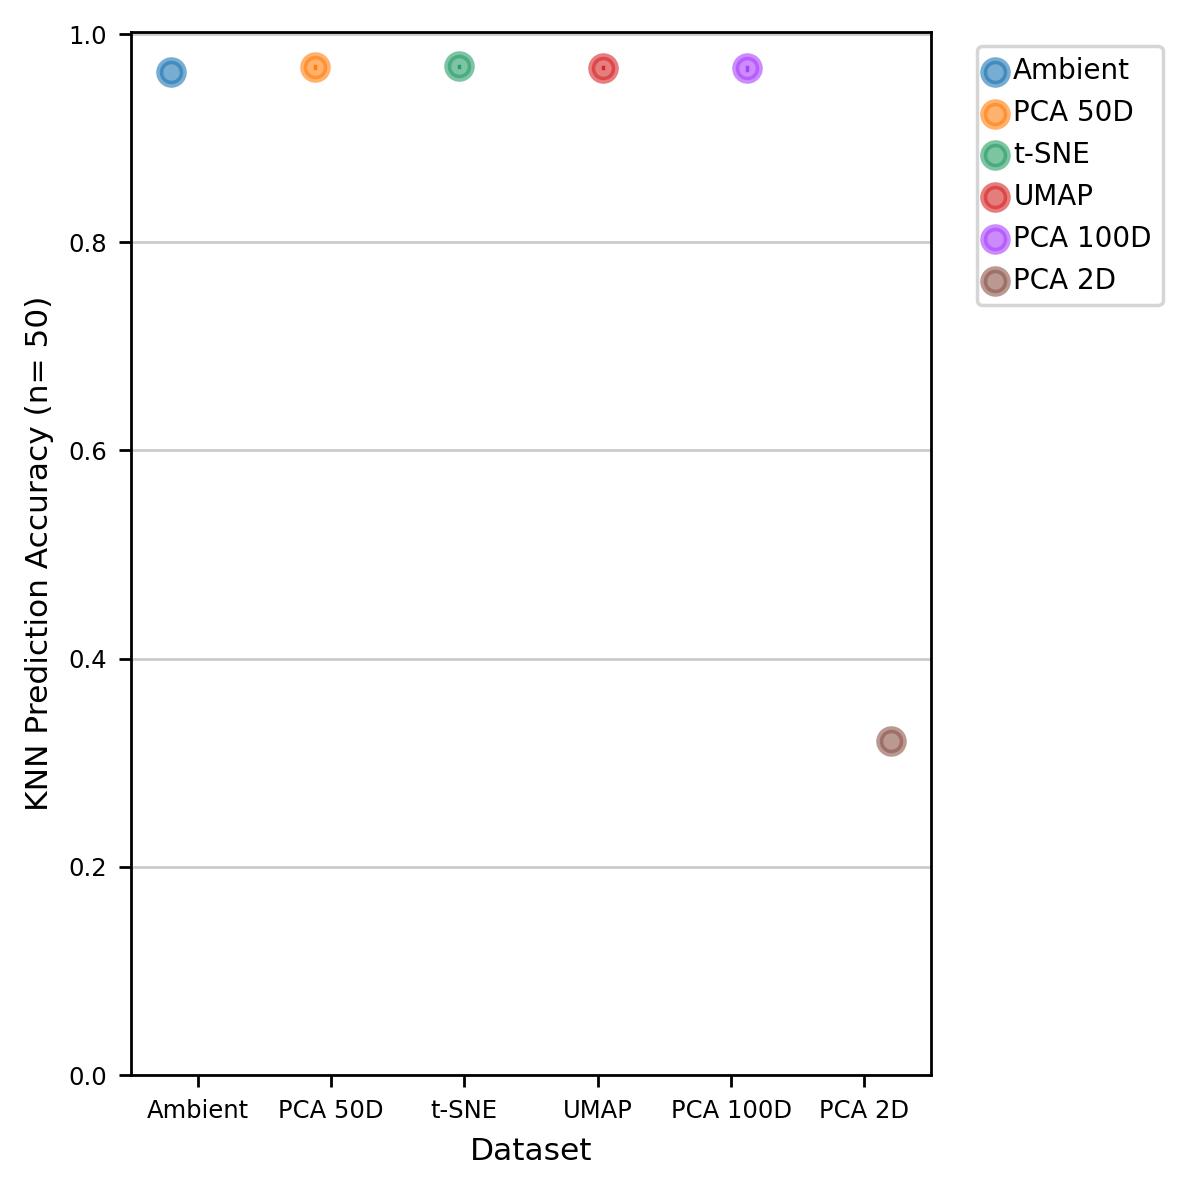

In [ ]:
plt.figure(figsize=(5,5))
g=sns.pointplot(x='Latent', y='Accuracy', data=finDF, hue='Latent', err_style='bars',join=False,plot_kws=dict(alpha=0.6),errwidth=errwidth, dodge=dodge)
plt.setp(g.collections, alpha=.6) #for the markers
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",prop={"size":8})

plt.ylim(ymin=0)

plt.xlabel("Dataset",fontsize=axisFontSize)
plt.ylabel("KNN Prediction Accuracy (n= 50)",fontsize=axisFontSize)
plt.xticks(fontsize=tickFontSize)
plt.yticks(fontsize=tickFontSize)
plt.tight_layout()
plt.show()

### **Smart-seq Data**

In [32]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [33]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [34]:
meta = pd.read_csv(data_path+'/smartmetadata.csv',index_col = 0)
meta.head()

sample_name  smartseq_cluster_id  \
SM-GE4R2_S062_E1-50  SM-GE4R2_S062_E1-50                   46   
SM-GE4SI_S356_E1-50  SM-GE4SI_S356_E1-50                   46   
SM-GE4SI_S172_E1-50  SM-GE4SI_S172_E1-50                   46   
LS-15034_S07_E1-50    LS-15034_S07_E1-50                   42   
LS-15034_S28_E1-50    LS-15034_S28_E1-50                   42   

                     smartseq_cluster sex_label smartseq_cluster_color  \
SM-GE4R2_S062_E1-50   Nr5a1_9|11 Rorb         M                #6C39A6   
SM-GE4SI_S356_E1-50   Nr5a1_9|11 Rorb         M                #6C39A6   
SM-GE4SI_S172_E1-50   Nr5a1_9|11 Rorb         M                #6C39A6   
LS-15034_S07_E1-50   Nr5a1_4|7 Glipr1         M                #763BFF   
LS-15034_S28_E1-50   Nr5a1_4|7 Glipr1         F                #763BFF   

                    medical_cond_label  cell_counts  n_genes  percent_mito  \
SM-GE4R2_S062_E1-50    behavior - none    964371.56     9772           0.0   
SM-GE4SI_S356_E1-50    behavior - none    973072.06     8253           0.0   
SM-GE4SI_S172_E1-50    behavior - none    977132.60     9394           0.0   
LS-15034_S07_E1-50     behavior - none    948605.44    10643           0.0   
LS-15034_S28_E1-50     behavior - none    951803.00    10550           0.0   

                     pass_count_filter  pass_mito_filter  
SM-GE4R2_S062_E1-50               True              True  
SM-GE4SI_S356_E1-50               True              True  
SM-GE4SI_S172_E1-50               True              True  
LS-15034_S07_E1-50                True              True  
LS-15034_S28_E1-50                True              True

In [35]:
lab1 = list(meta.smartseq_cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.medical_cond_label)


allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.smartseq_cluster_color))

sex_colors = ['#abacb7','#F8C471']

In [36]:
latents,latentLab,latentType = latentComp(scaled_mat, count_mat, ndims=2, pcs=[50,100], rounds = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

In [37]:
latentLab

['Ambient',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP']

Check internal distances in clusters

In [38]:
allNeigh = getAllNeigh(latents,latentLab,latentType,meta.smartseq_cluster)
allNeigh.head()

Latent       Tau
0  PCA 50D  0.761905
1  PCA 50D  0.666667
2  PCA 50D  0.730159
3  PCA 50D  0.756614
4  PCA 50D  0.783069

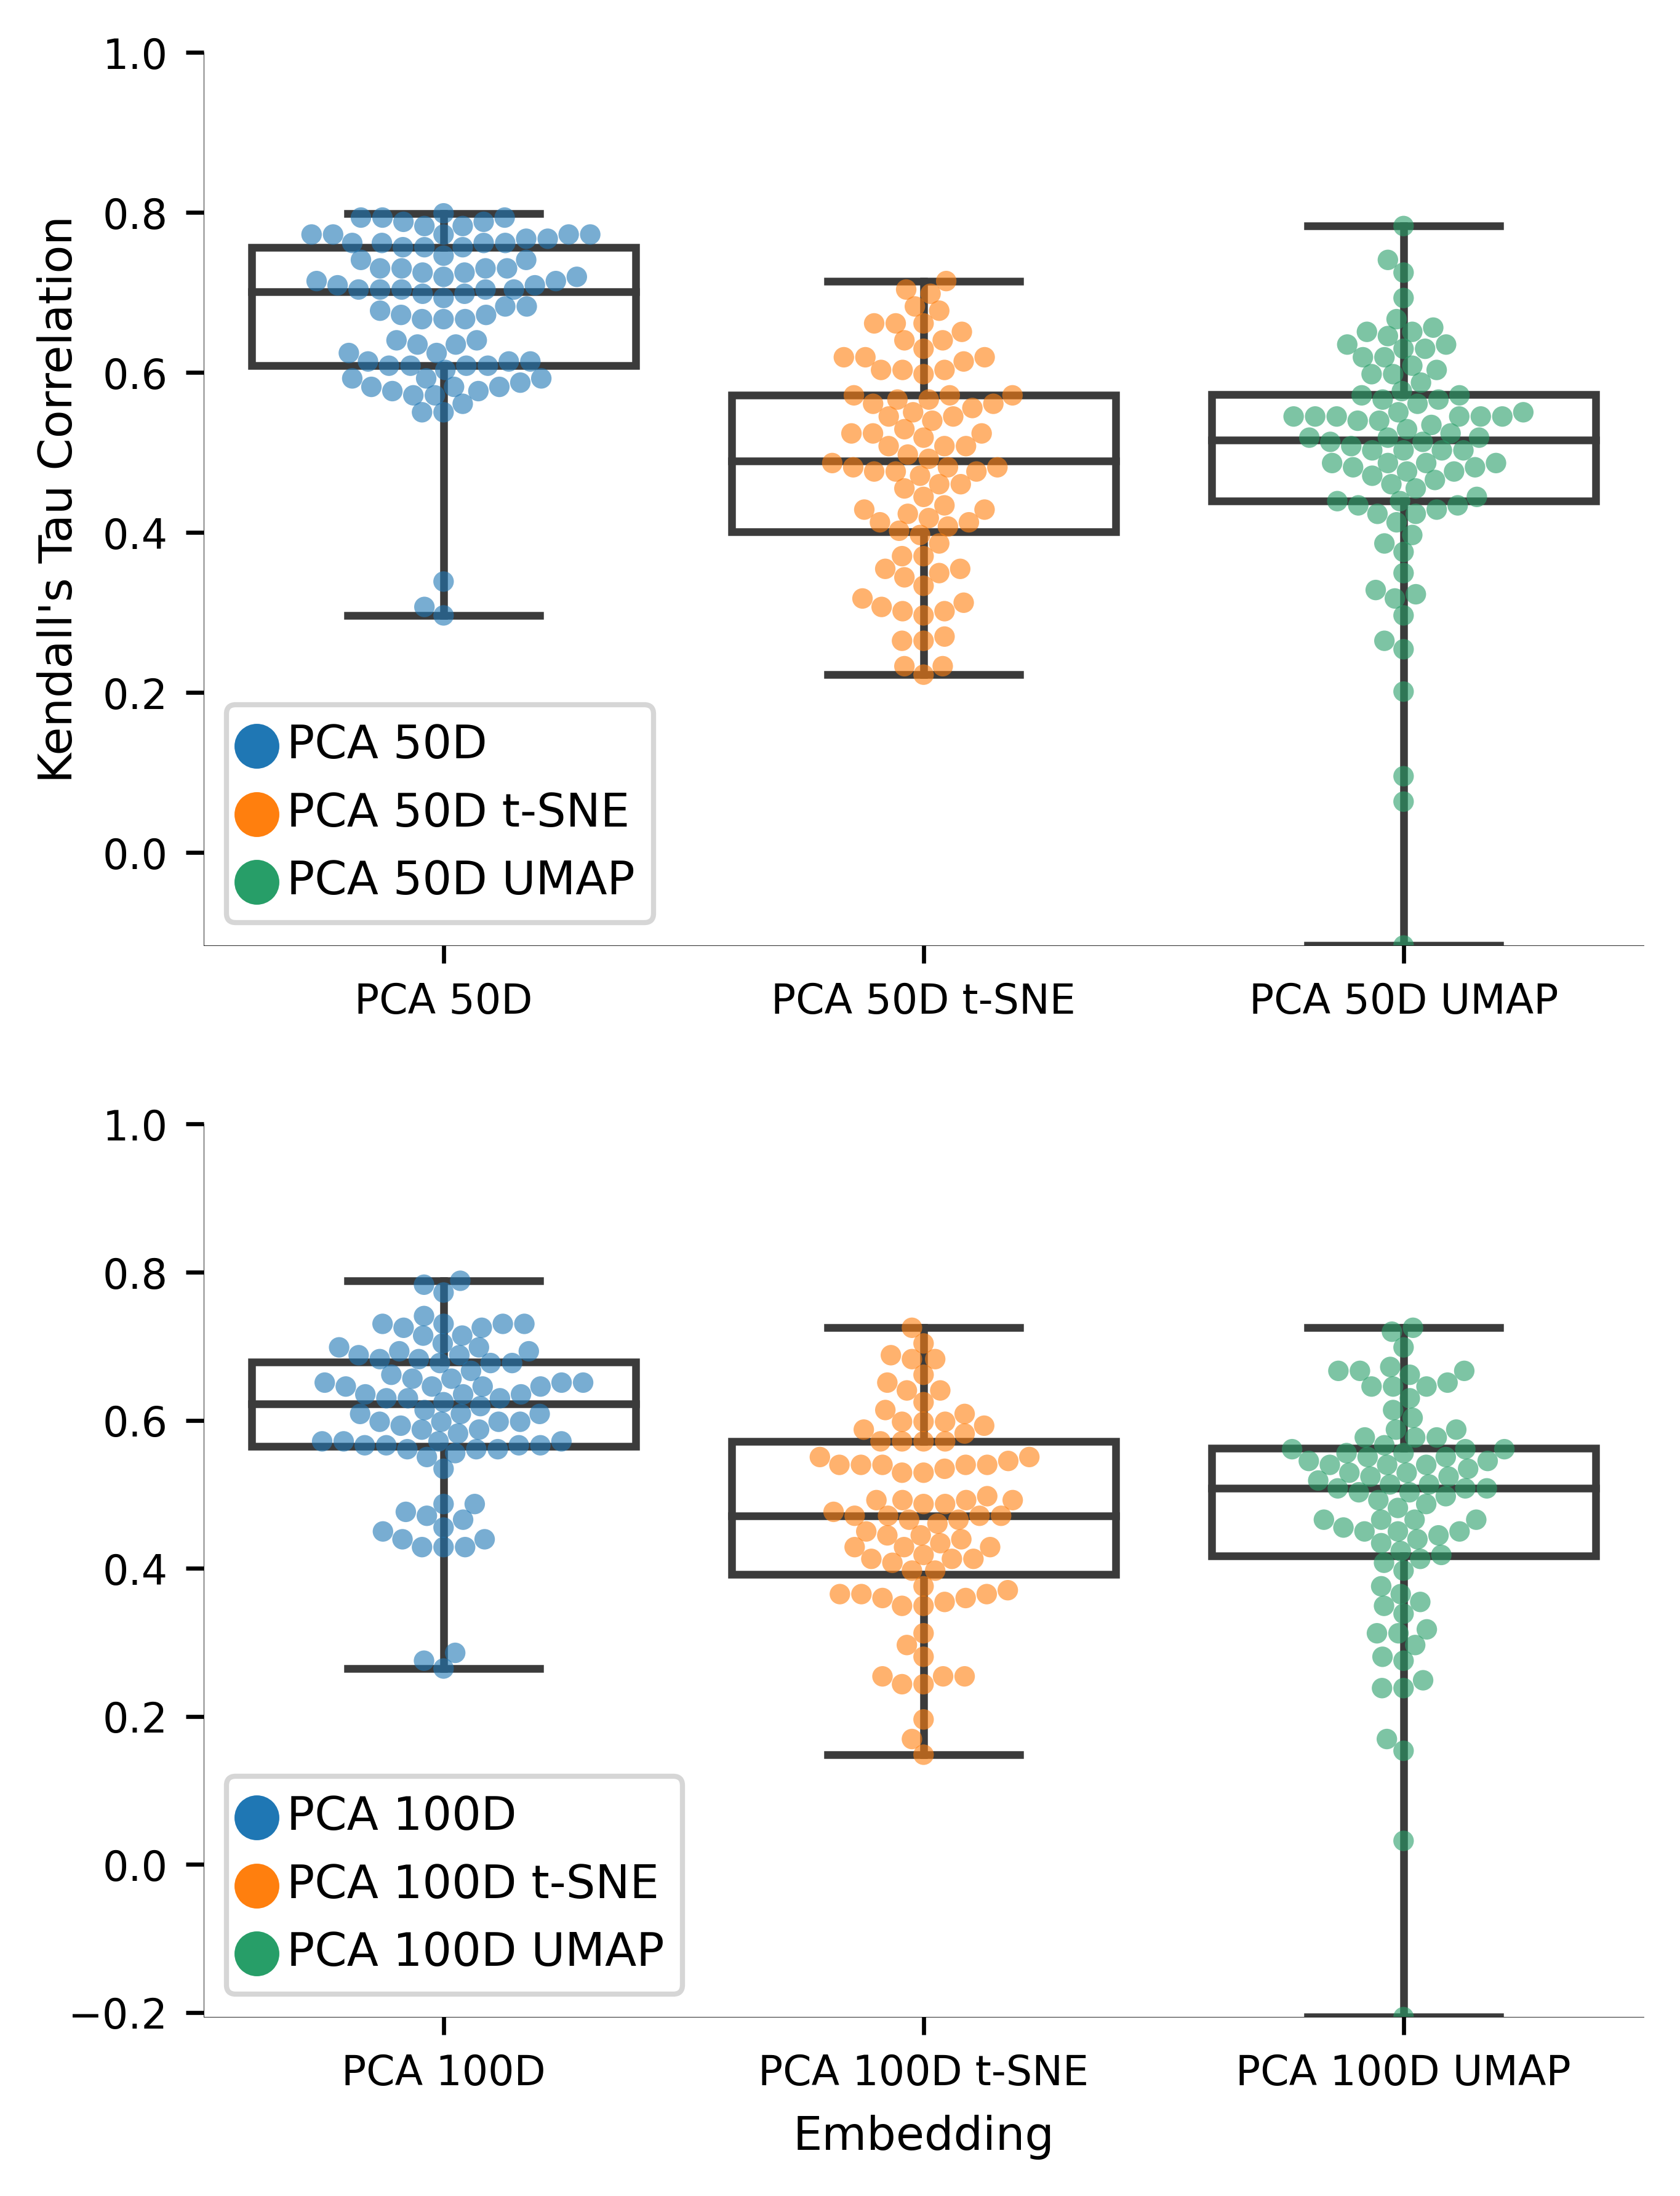

In [39]:
plotNeigh(allNeigh,size=4)

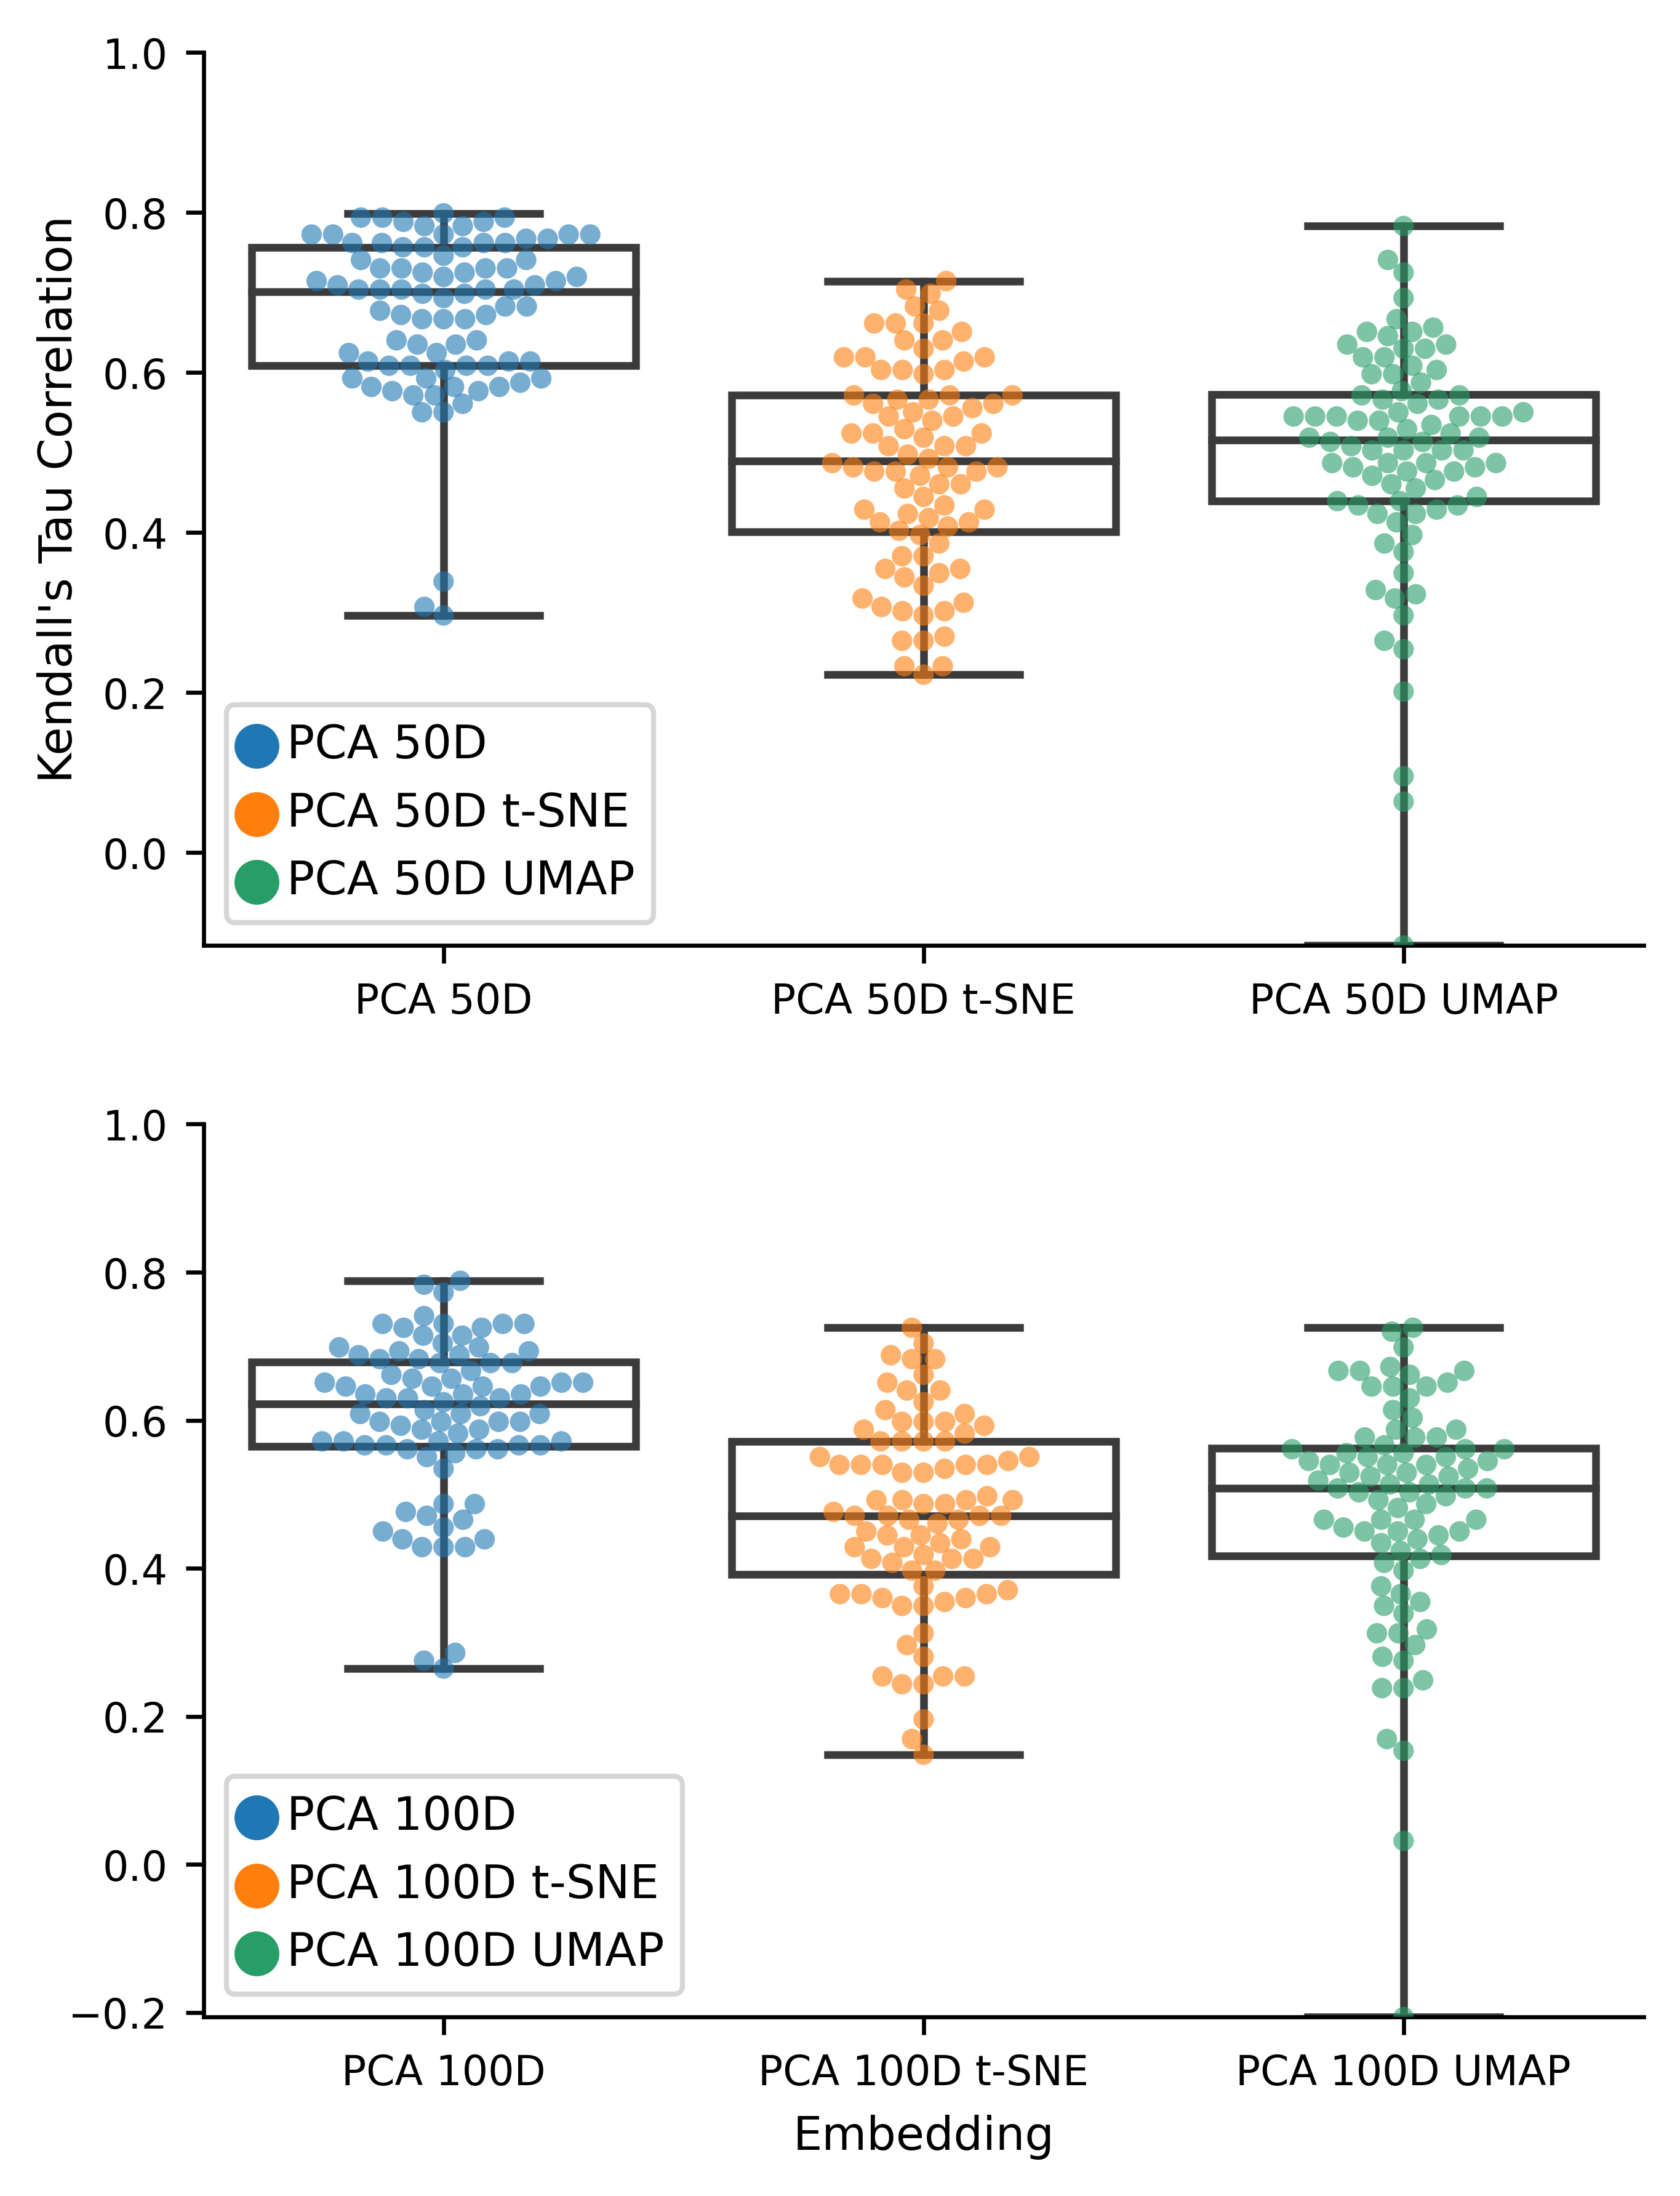

In [41]:
plotNeigh(allNeigh,size=4)

In [42]:
inds = [[1,2,3],[7,8,9],[13,14,15]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],meta.smartseq_cluster)]
d50 = pd.concat(dfs)
d50.head()

Latent       Tau
0  PCA 50D t-SNE  0.322751
1  PCA 50D t-SNE  0.296296
2  PCA 50D t-SNE  0.238095
3  PCA 50D t-SNE  0.333333
4  PCA 50D t-SNE  0.343915

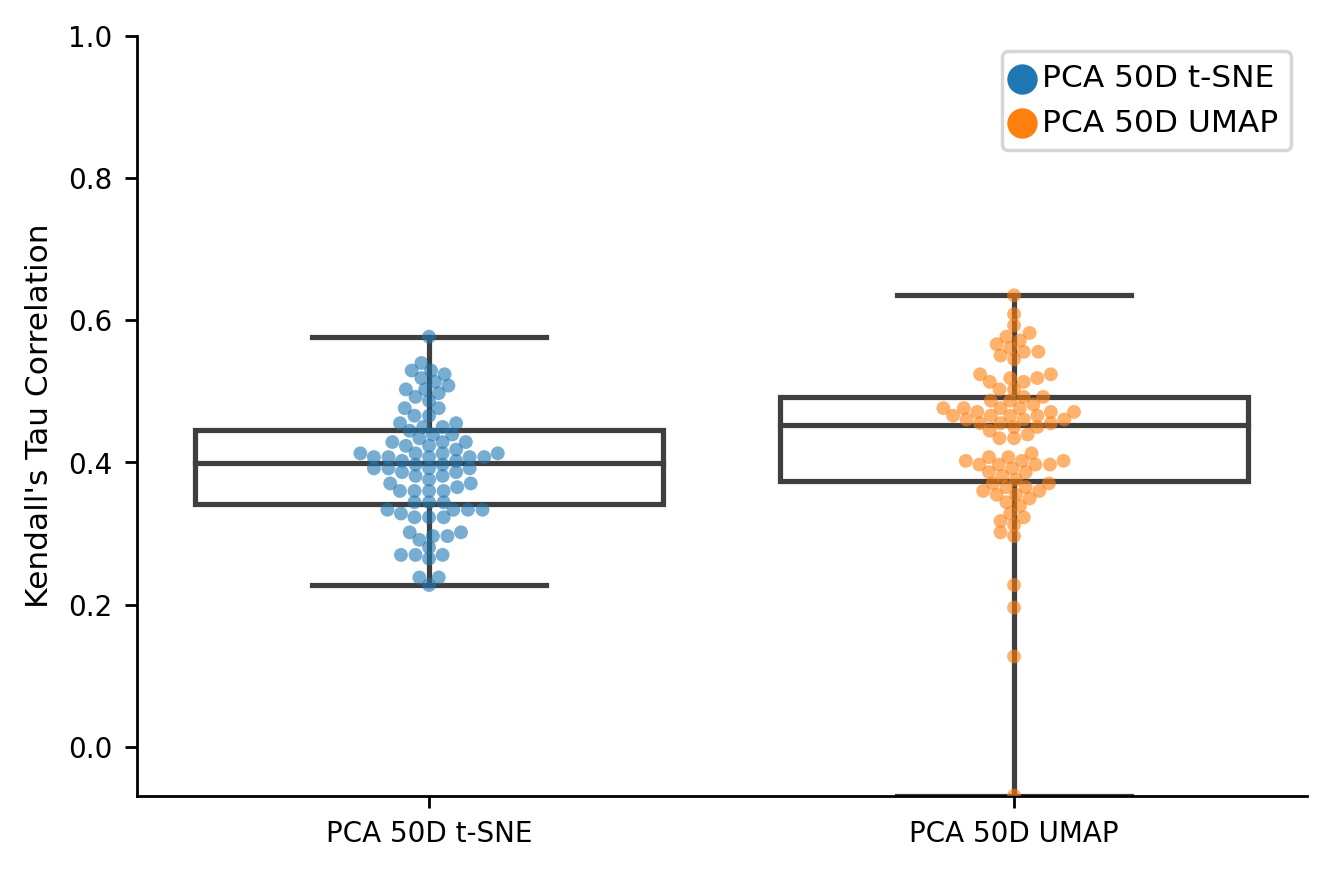

In [43]:
plotNeighSingle(d50[~d50['Latent'].isin(['PCA 50D'])],size=4,figsize=(6,4))

In [44]:
inds = [[4,5,6],[10,11,12],[16,17,18]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],meta.smartseq_cluster)]
d100 = pd.concat(dfs)
d100.head()

Latent       Tau
0  PCA 100D t-SNE  0.280423
1  PCA 100D t-SNE  0.211640
2  PCA 100D t-SNE  0.201058
3  PCA 100D t-SNE  0.465608
4  PCA 100D t-SNE  0.343915

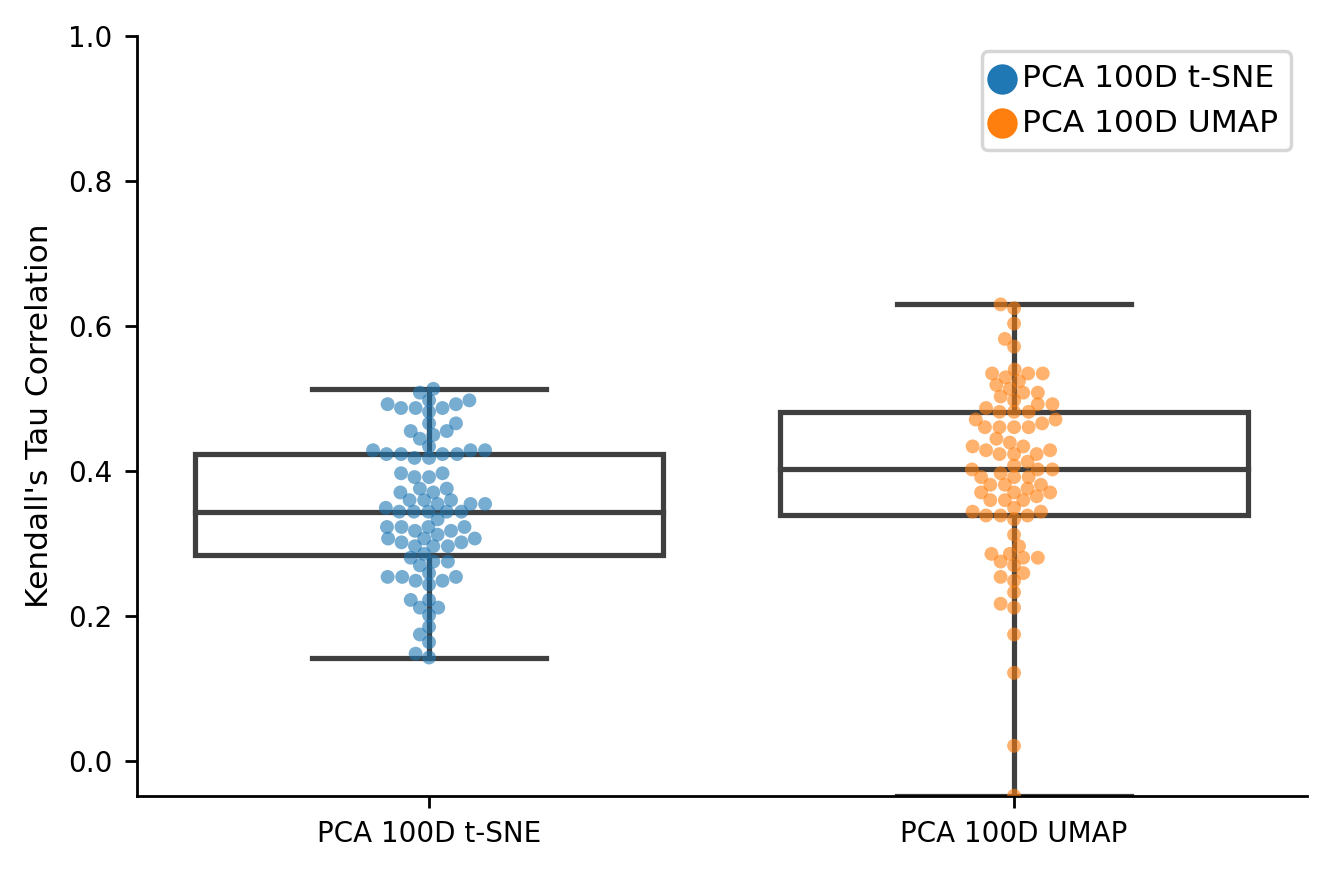

In [45]:
plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

Set Ambient Data

In [ ]:
allVals = getAllVars(latents,latentLab,latentType,meta.smartseq_cluster)
allVals.head()

Latent    Distance      Value
0  Ambient  Inter-Type  76.036344
1  Ambient  Inter-Type  75.836817
2  Ambient  Inter-Type  77.861511
3  Ambient  Inter-Type  75.896045
4  Ambient  Inter-Type  74.057349

In [ ]:
np.unique(allVals.Latent)

array(['Ambient', 'PCA 100D', 'PCA 100D UMAP', 'PCA 100D t-SNE',
       'PCA 50D', 'PCA 50D UMAP', 'PCA 50D t-SNE'], dtype=object)

Scale all distributions to same mean (from Ambient)

In [ ]:
test = allVals.copy()

In [ ]:
sub = test[test['Latent'].isin(['Ambient'])]
avg = np.mean(sub['Value'])

In [ ]:
dfs = []
for i in np.unique(test['Latent']):
  sub = test[test['Latent'].isin([i])]
  sub['Value'] = sub['Value'] - np.mean(sub['Value']) + avg
  #sub['Value'][sub['Distance'].isin(['Intra-Type'])] = sub['Value'][sub['Distance'].isin(['Intra-Type'])] - np.mean(sub['Value'][sub['Distance'].isin(['Intra-Type'])]) + avg
  sub['KS'] = [stats.ks_2samp(np.array(sub['Value'][sub['Distance'].isin(['Inter-Type'])].tolist()),np.array(sub['Value'][sub['Distance'].isin(['Intra-Type'])].tolist()))]*len(sub['Value'])

  
  dfs += [sub]

newVals = pd.concat(dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


KstestResult(statistic=0.9325396825396826, pvalue=1.2212453270876722e-15)
KstestResult(statistic=0.8328924162257496, pvalue=0.0)
KstestResult(statistic=0.9298941798941799, pvalue=0.0)
KstestResult(statistic=0.9312169312169312, pvalue=0.0)
KstestResult(statistic=0.931657848324515, pvalue=0.0)
KstestResult(statistic=0.9488536155202821, pvalue=0.0)
KstestResult(statistic=0.9453262786596119, pvalue=0.0)


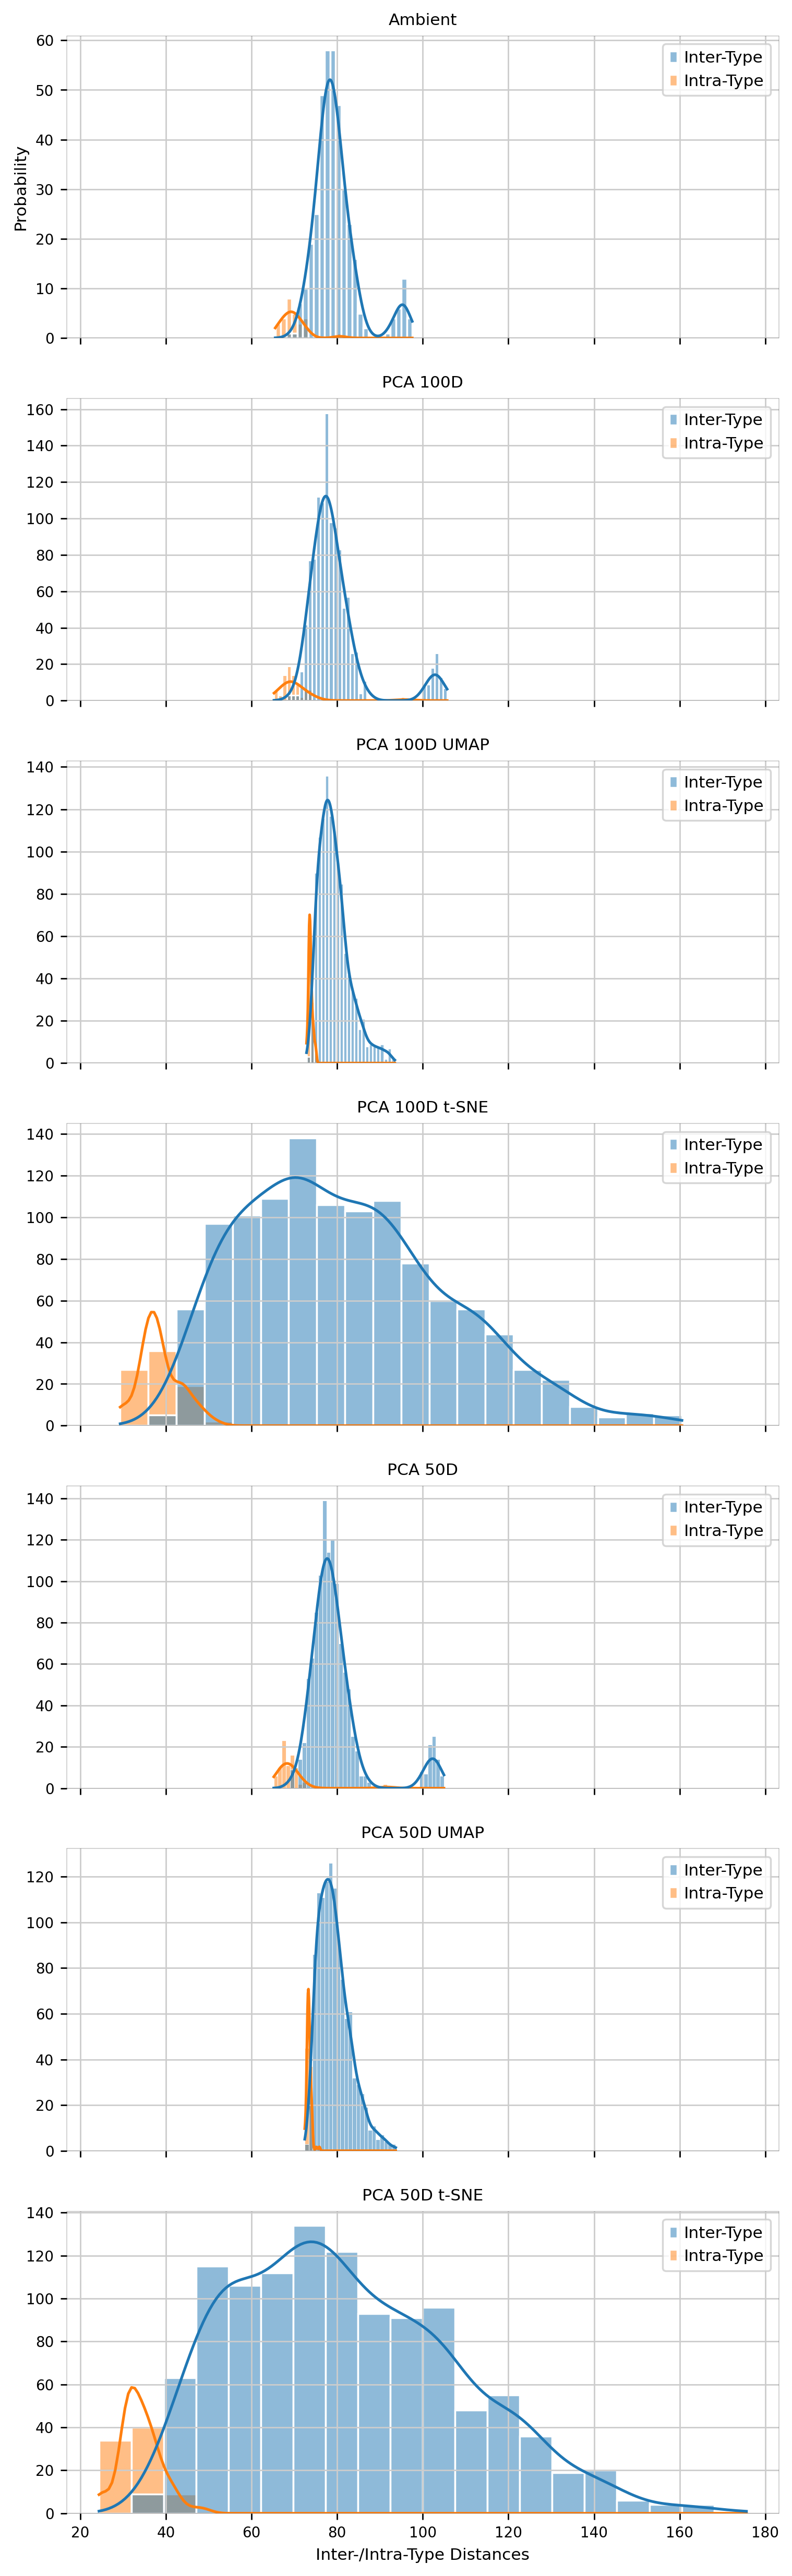

In [ ]:
plotAmb(newVals)

### **10X VMH data**

In [31]:
count_mat = sio.mmread(data_path+'/tenx.mtx')
count_mat.shape

(41580, 1999)

In [32]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [33]:
meta = pd.read_csv(data_path+'/tenxmetadata.csv',index_col = 0)
meta.head()

sample_name        cell_barcode cluster_color      cluster  \
0  10x_VMH_Female_Control_1  4_AAACCTGAGCGCCTCA       #9162FF      Nr5a1_4   
1  10x_VMH_Female_Control_1  4_AAACCTGCACAGTCGC       #96FF2E  Tsix_Esr1_1   
2  10x_VMH_Female_Control_1  4_AAACCTGCAGATTGCT       #66ABC2       Dlk1_3   
3  10x_VMH_Female_Control_1  4_AAACCTGCATACTCTT       #96FF2E  Tsix_Esr1_1   
4  10x_VMH_Female_Control_1  4_AAACCTGGTCCGTTAA       #24EFCD         Scgn   

   cluster_id cell_types sex_label  batch_indices  cell_counts  n_genes  \
0        24.0  undefined         F              0       1427.0      926   
1         3.0  undefined         F              0       4508.0     2310   
2        16.0  undefined         F              0       3447.0     1995   
3         3.0  undefined         F              0       7004.0     3286   
4        20.0  undefined         F              0       2490.0     1492   

   percent_mito  pass_count_filter  pass_mito_filter  
0     13.594954               True             False  
1      9.272405               True             False  
2      5.483029               True             False  
3      4.483152               True              True  
4      9.277108               True             False

In [34]:
lab1 = list(meta.cluster)
lab2 = list(meta.sex_label)
# lab3 = list(meta.medical_cond_label)
lab4 = list(meta.cluster)

allLabs = np.array([lab1])
allLabs2 = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.cluster_color))

sex_colors = ['#abacb7','#F8C471']

In [35]:
latents,latentLab,latentType = latentComp(scaled_mat, count_mat, ndims=2, pcs=[50,100], rounds = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

In [36]:
latentLab

['Ambient',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP']

Check internal distances in clusters

In [37]:
allNeigh = getAllNeigh(latents,latentLab,latentType,meta.cluster)
allNeigh.head()

Latent       Tau
0  PCA 50D  0.733333
1  PCA 50D  0.705747
2  PCA 50D  0.659770
3  PCA 50D  0.664368
4  PCA 50D  0.728736

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


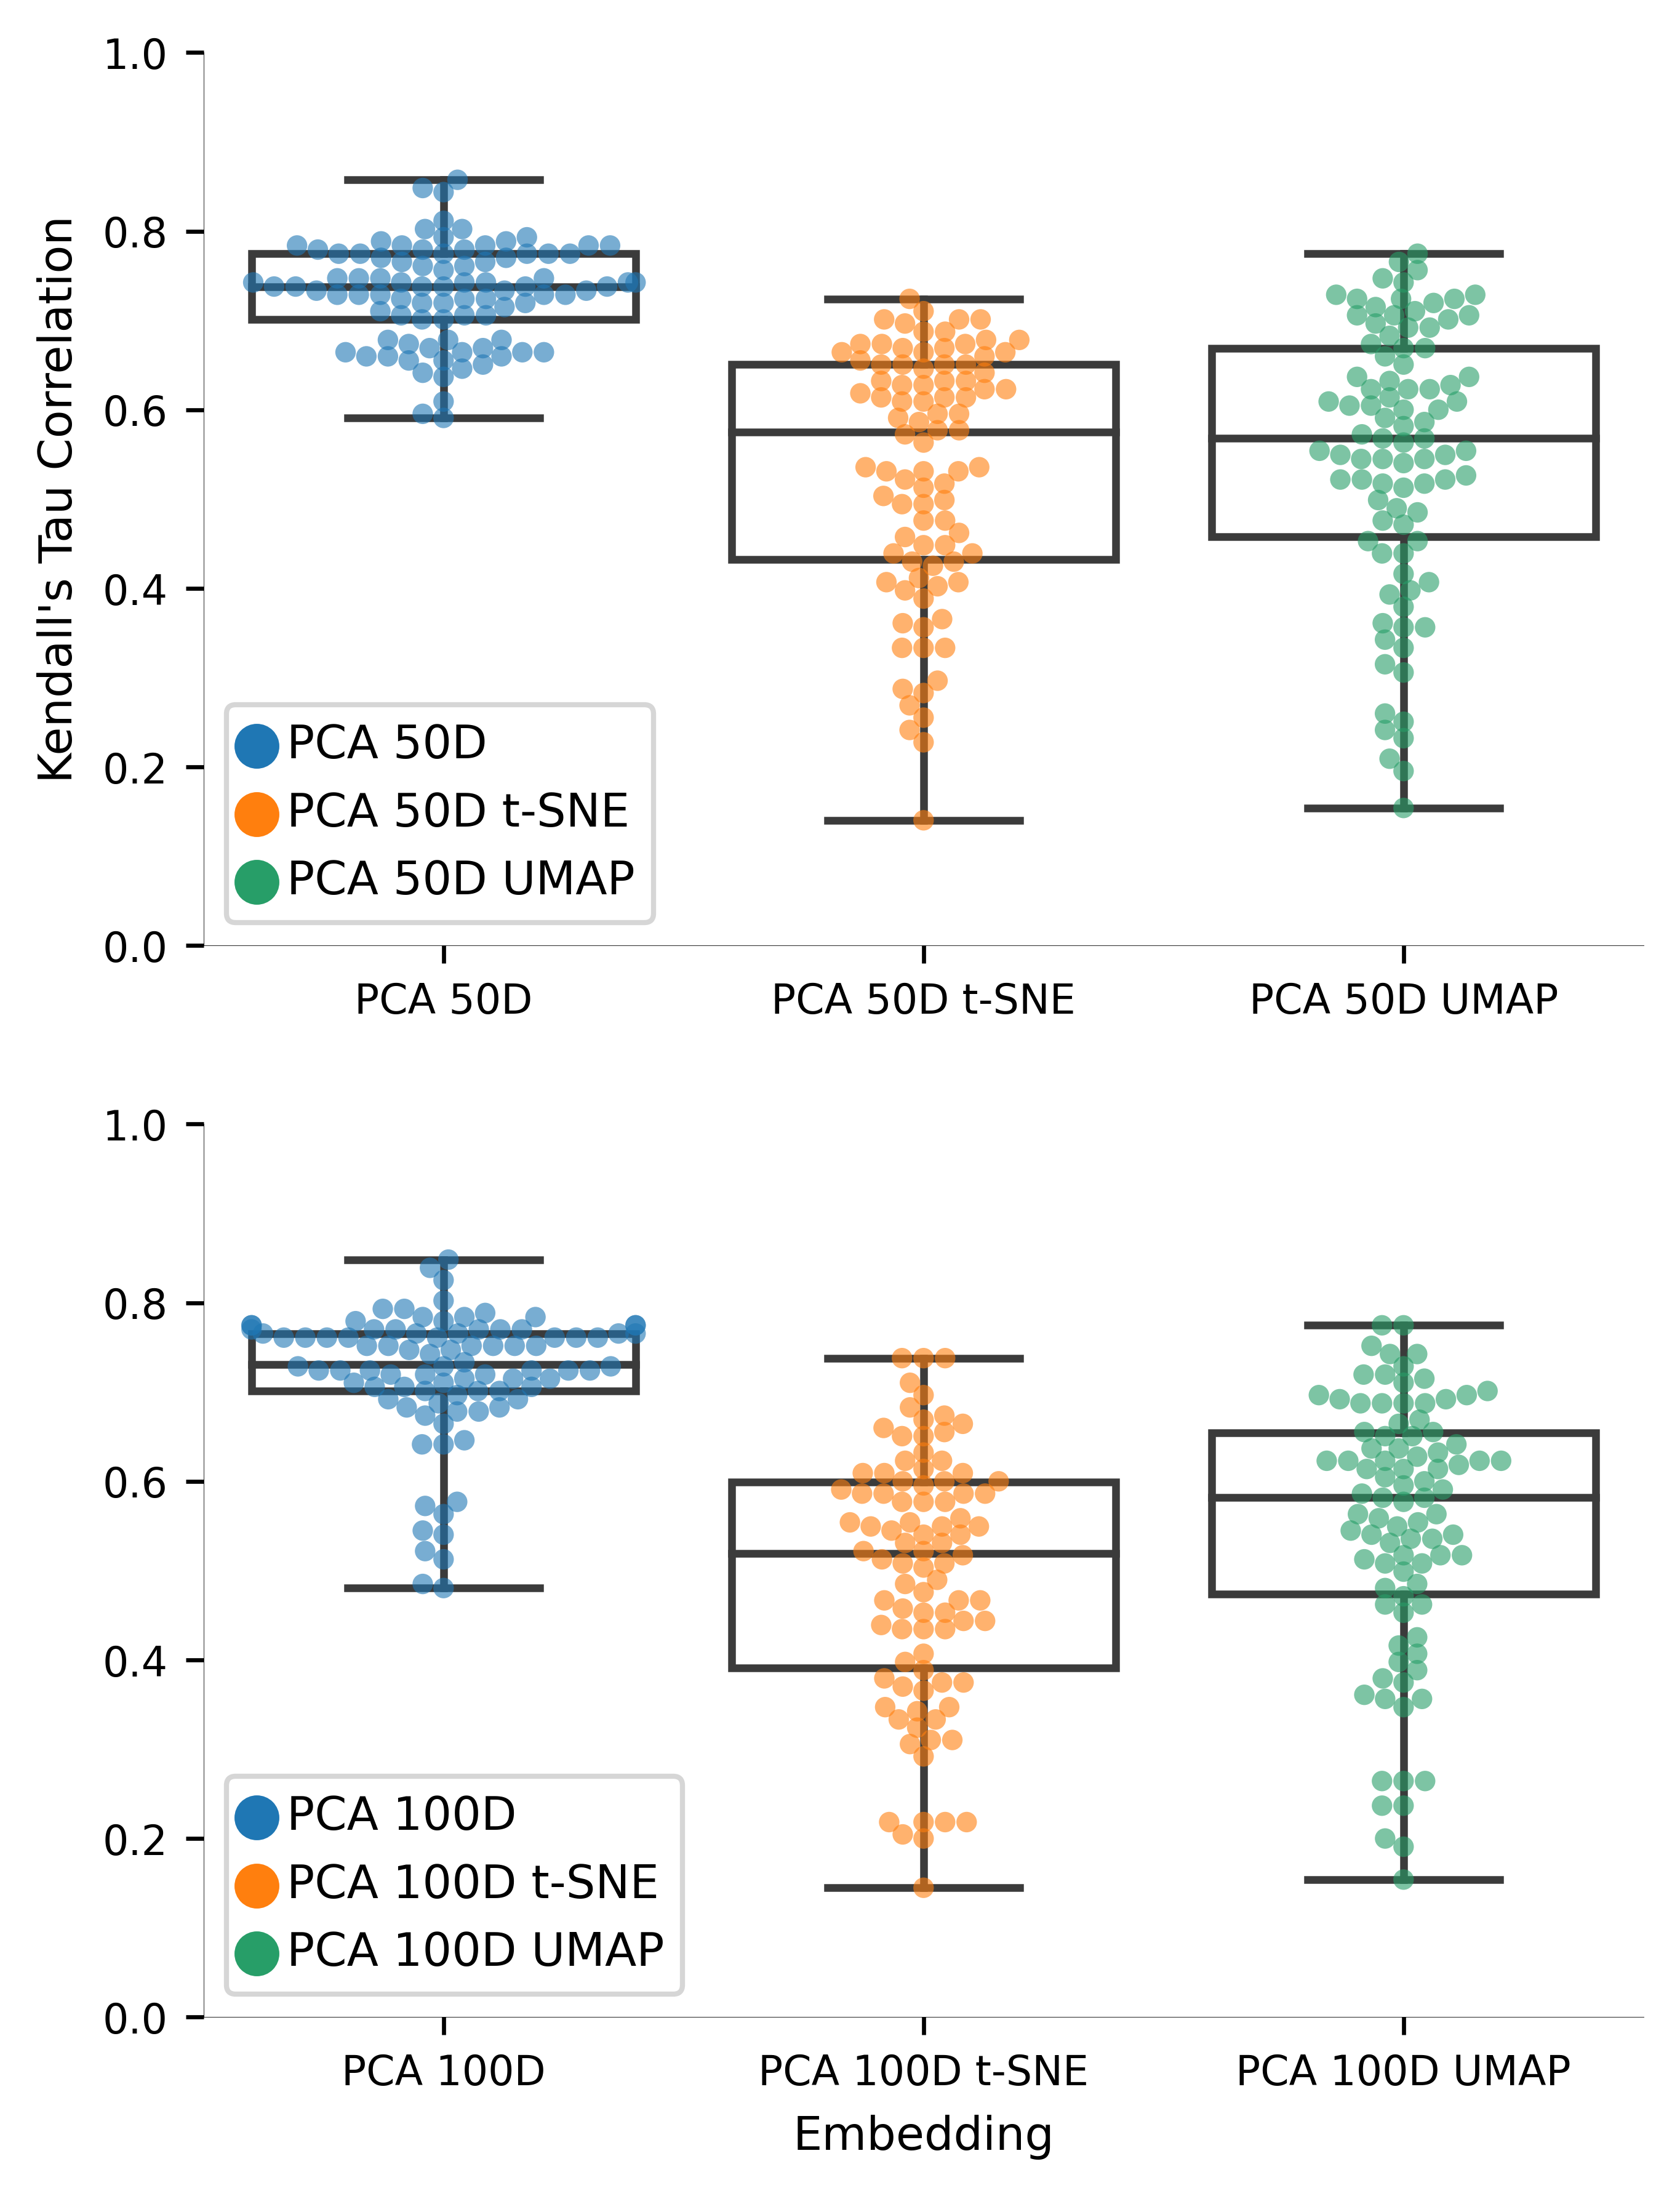

In [38]:
plotNeigh(allNeigh,size=4)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


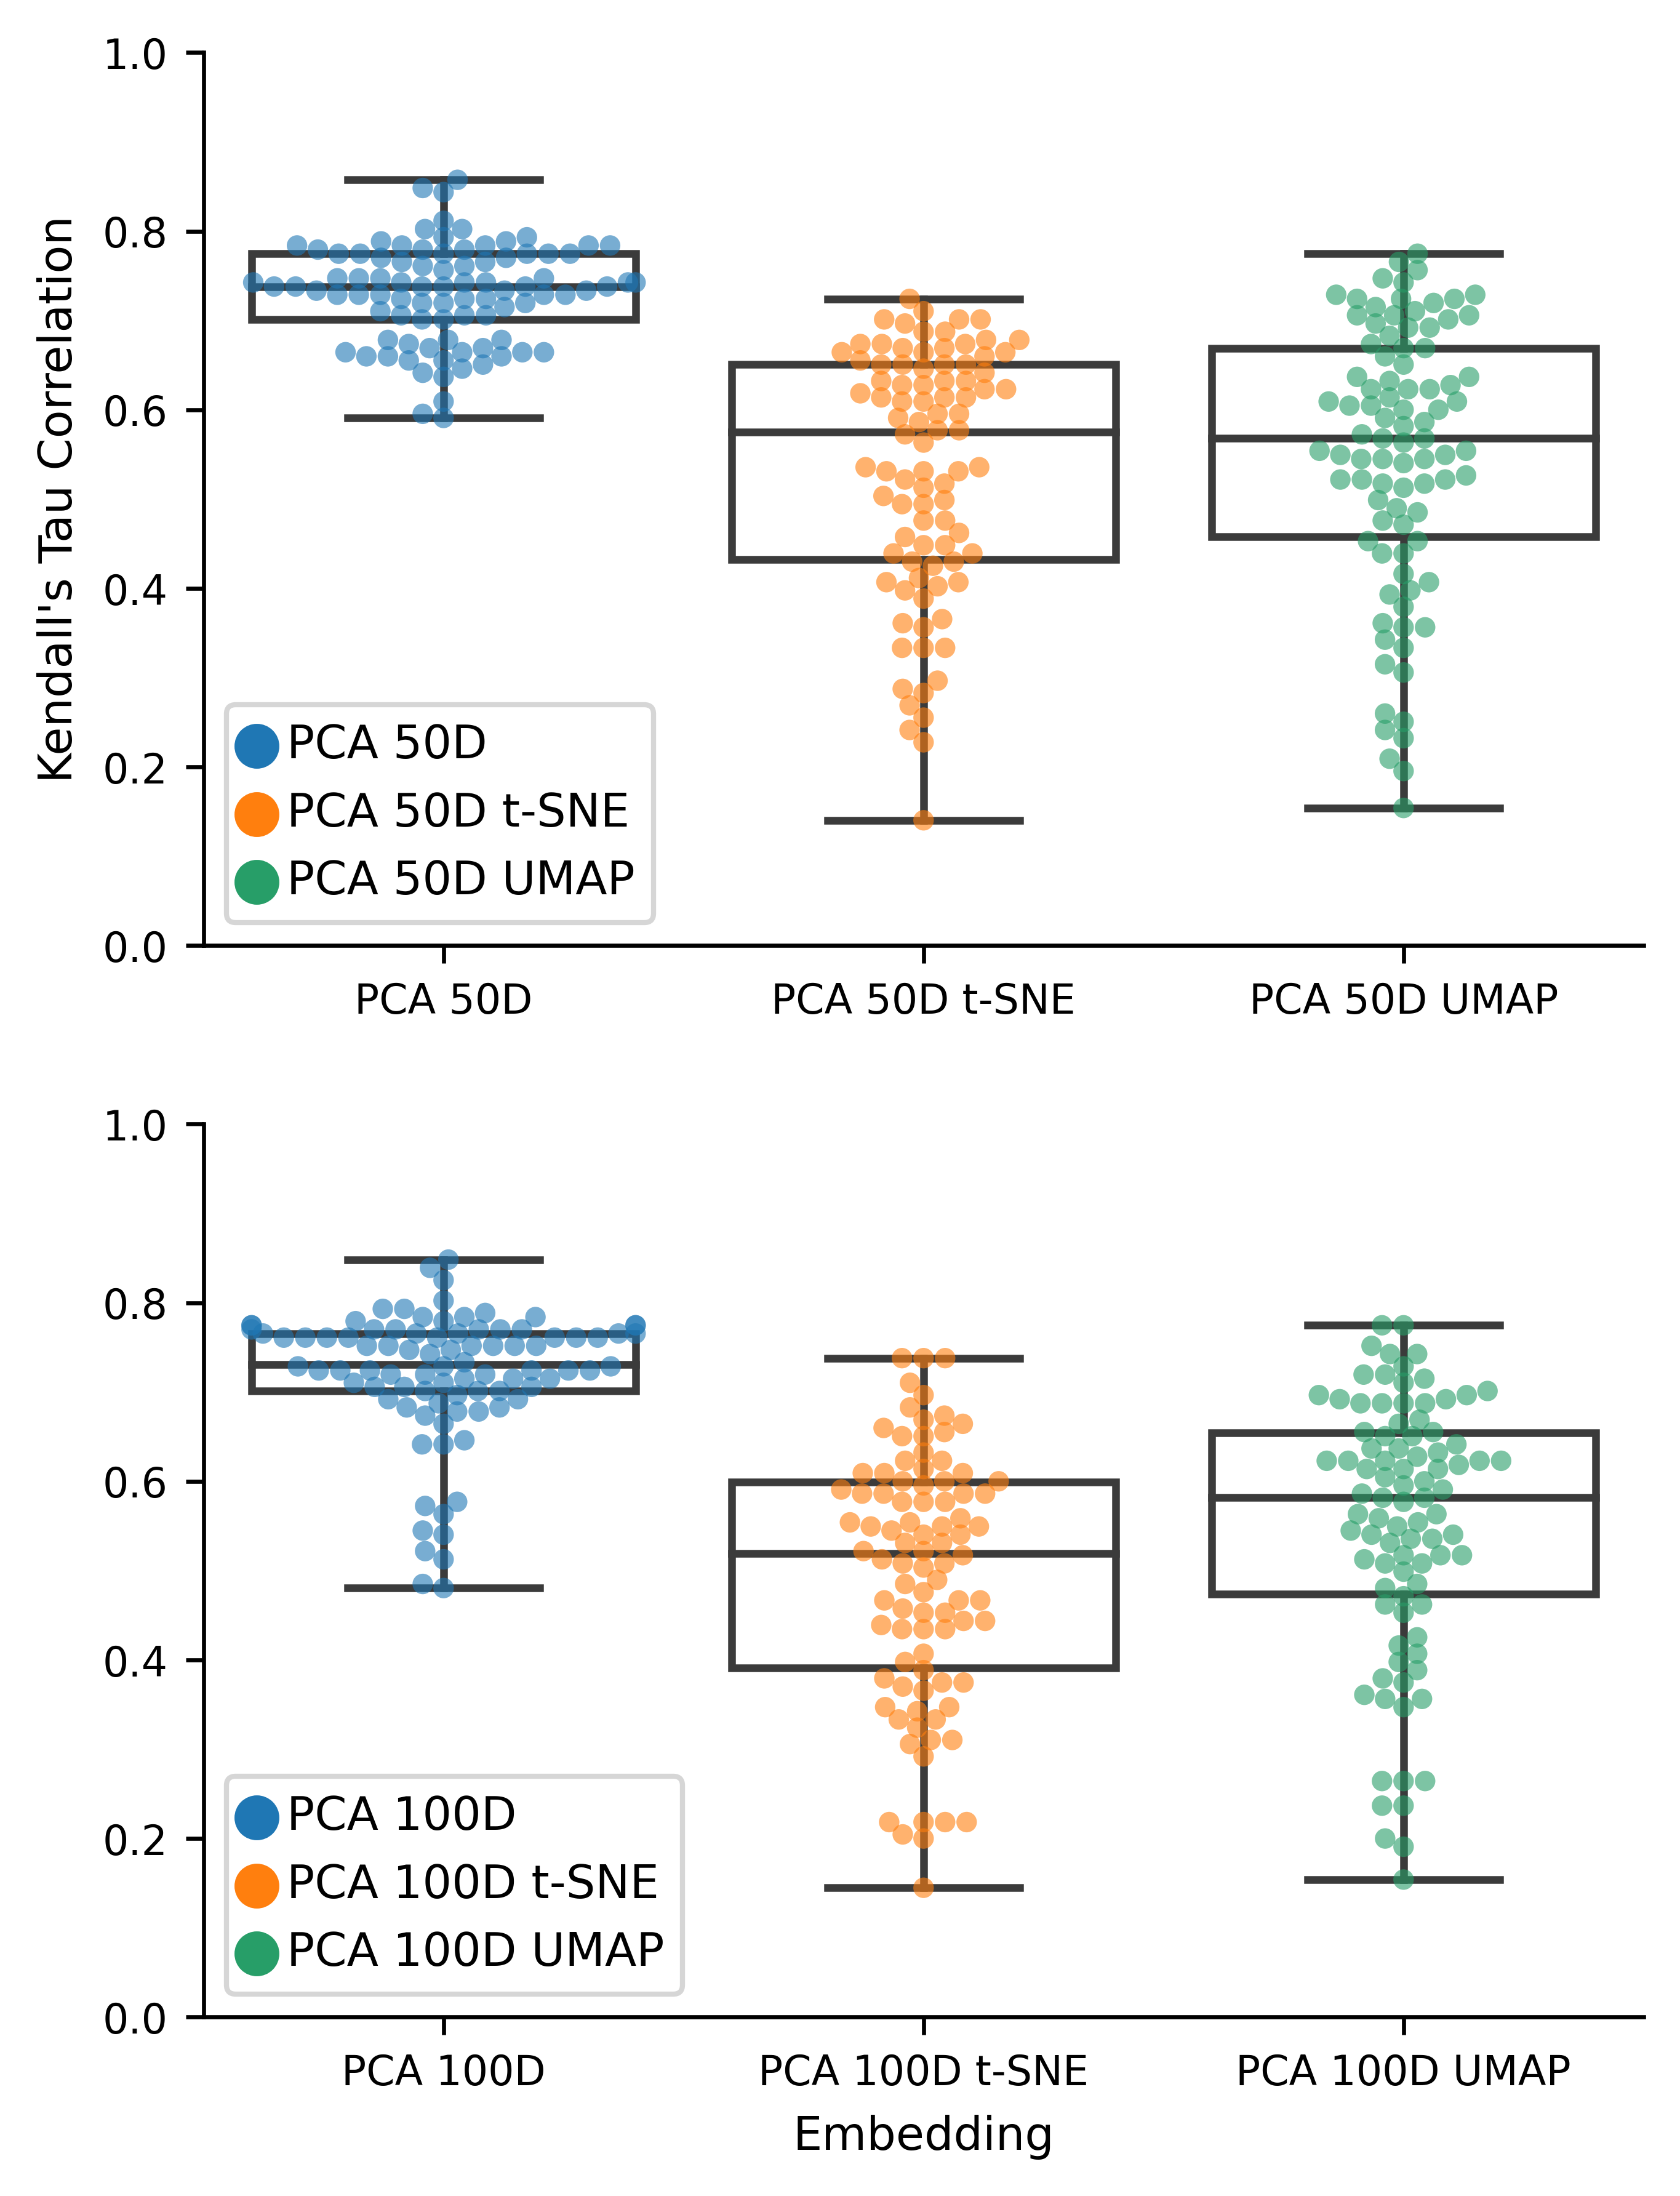

In [40]:
plotNeigh(allNeigh,size=4)

In [41]:
inds = [[1,2,3],[7,8,9],[13,14,15]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],meta.cluster)]
d50 = pd.concat(dfs)
d50.head()

Latent       Tau
0  PCA 50D t-SNE  0.650575
1  PCA 50D t-SNE  0.489655
2  PCA 50D t-SNE  0.521839
3  PCA 50D t-SNE  0.590805
4  PCA 50D t-SNE  0.659770

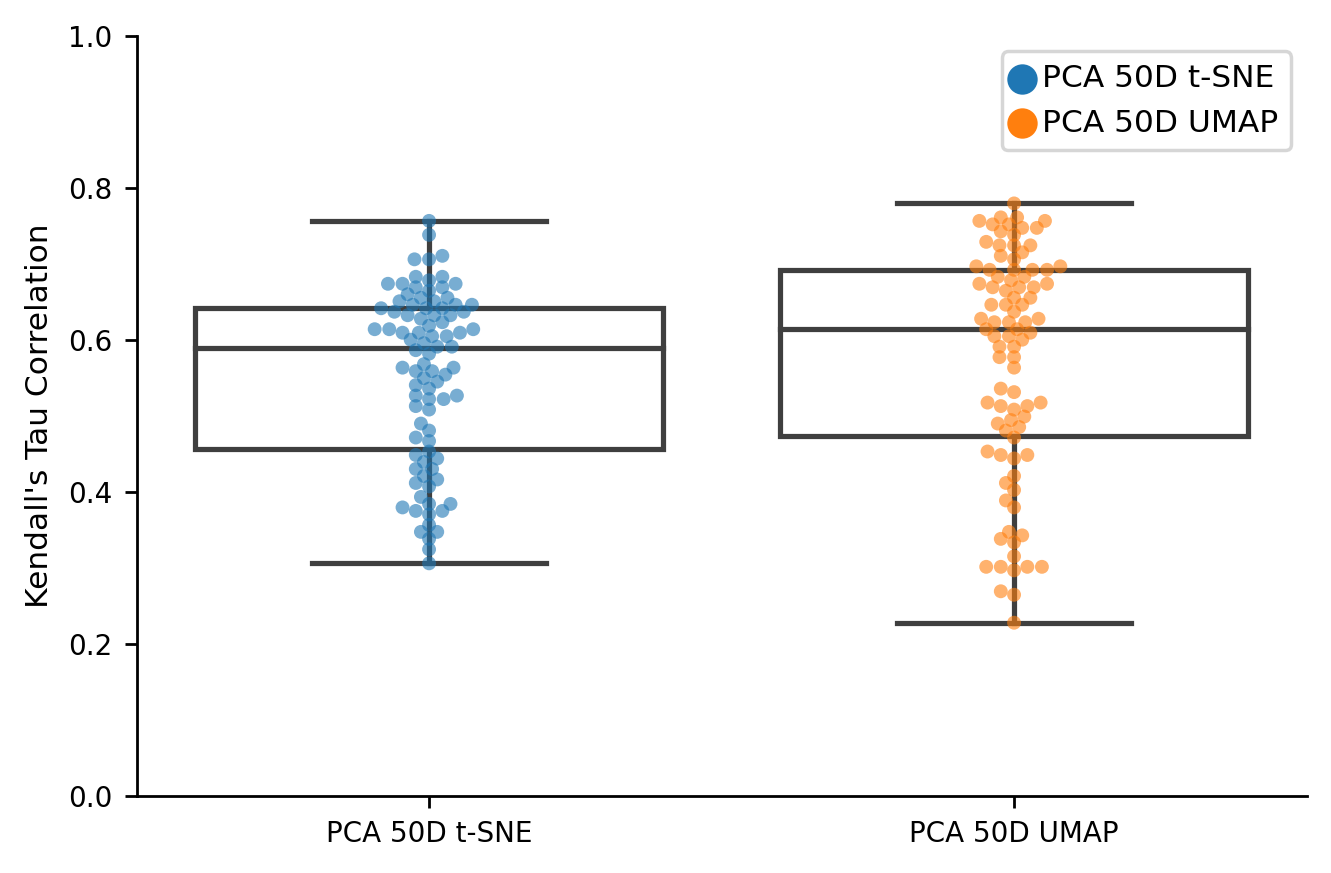

In [42]:
plotNeighSingle(d50[~d50['Latent'].isin(['PCA 50D'])],size=4,figsize=(6,4))

In [43]:
inds = [[4,5,6],[10,11,12],[16,17,18]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],meta.cluster)]
d100 = pd.concat(dfs)
d100.head()

Latent       Tau
0  PCA 100D t-SNE  0.521839
1  PCA 100D t-SNE  0.351724
2  PCA 100D t-SNE  0.337931
3  PCA 100D t-SNE  0.305747
4  PCA 100D t-SNE  0.452874

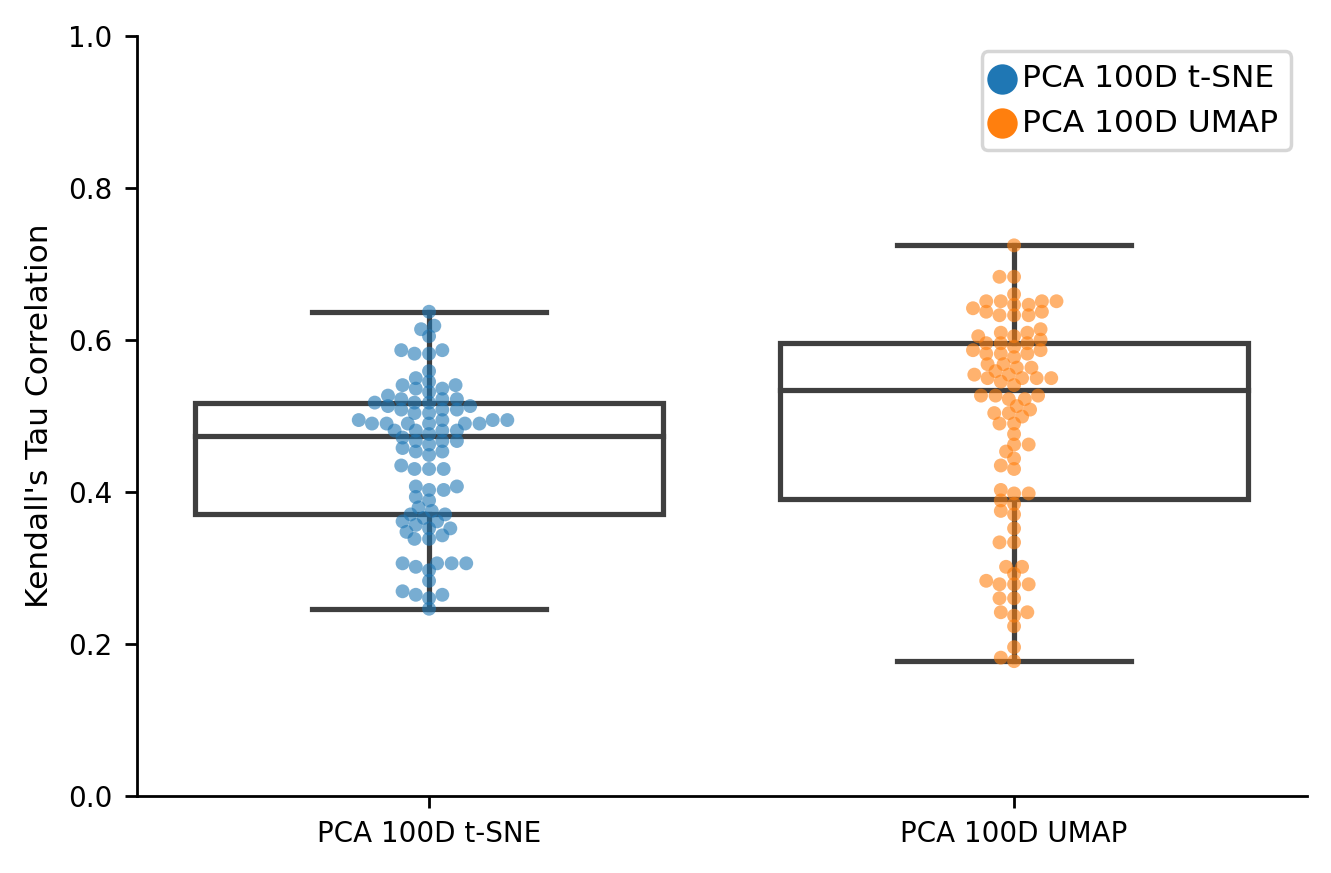

In [44]:
plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

Set Ambient Data

In [ ]:
allVals = getAllVars(latents,latentLab,latentType,meta.cluster)
allVals.head()

Latent    Distance        Value
0  Ambient  Inter-Type  1386.301564
1  Ambient  Inter-Type  1409.420499
2  Ambient  Inter-Type  1385.325835
3  Ambient  Inter-Type  1375.171269
4  Ambient  Inter-Type  1370.594084

In [ ]:
np.unique(allVals.Latent)

array(['Ambient', 'PCA 100D', 'PCA 100D UMAP', 'PCA 100D t-SNE',
       'PCA 50D', 'PCA 50D UMAP', 'PCA 50D t-SNE'], dtype=object)

Scale all distributions to same mean (from Ambient)

In [ ]:
test = allVals.copy()

In [ ]:
sub = test[test['Latent'].isin(['Ambient'])]
avg = np.mean(sub['Value'])

In [ ]:
dfs = []
for i in np.unique(test['Latent']):
  sub = test[test['Latent'].isin([i])]
  sub['Value'] = sub['Value'] - np.mean(sub['Value']) + avg
  #sub['Value'][sub['Distance'].isin(['Intra-Type'])] = sub['Value'][sub['Distance'].isin(['Intra-Type'])] - np.mean(sub['Value'][sub['Distance'].isin(['Intra-Type'])]) + avg
  sub['KS'] = [stats.ks_2samp(np.array(sub['Value'][sub['Distance'].isin(['Inter-Type'])].tolist()),np.array(sub['Value'][sub['Distance'].isin(['Intra-Type'])].tolist()))]*len(sub['Value'])

  
  dfs += [sub]

newVals = pd.concat(dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Ks_2sampResult(statistic=0.7540229885057471, pvalue=1.5543122344752192e-15)
Ks_2sampResult(statistic=0.7003831417624521, pvalue=9.992007221626409e-16)
Ks_2sampResult(statistic=0.7946360153256705, pvalue=9.992007221626409e-16)
Ks_2sampResult(statistic=0.8409961685823755, pvalue=9.992007221626409e-16)
Ks_2sampResult(statistic=0.8555555555555555, pvalue=9.992007221626409e-16)
Ks_2sampResult(statistic=0.8095785440613027, pvalue=9.992007221626409e-16)
Ks_2sampResult(statistic=0.7881226053639847, pvalue=9.992007221626409e-16)


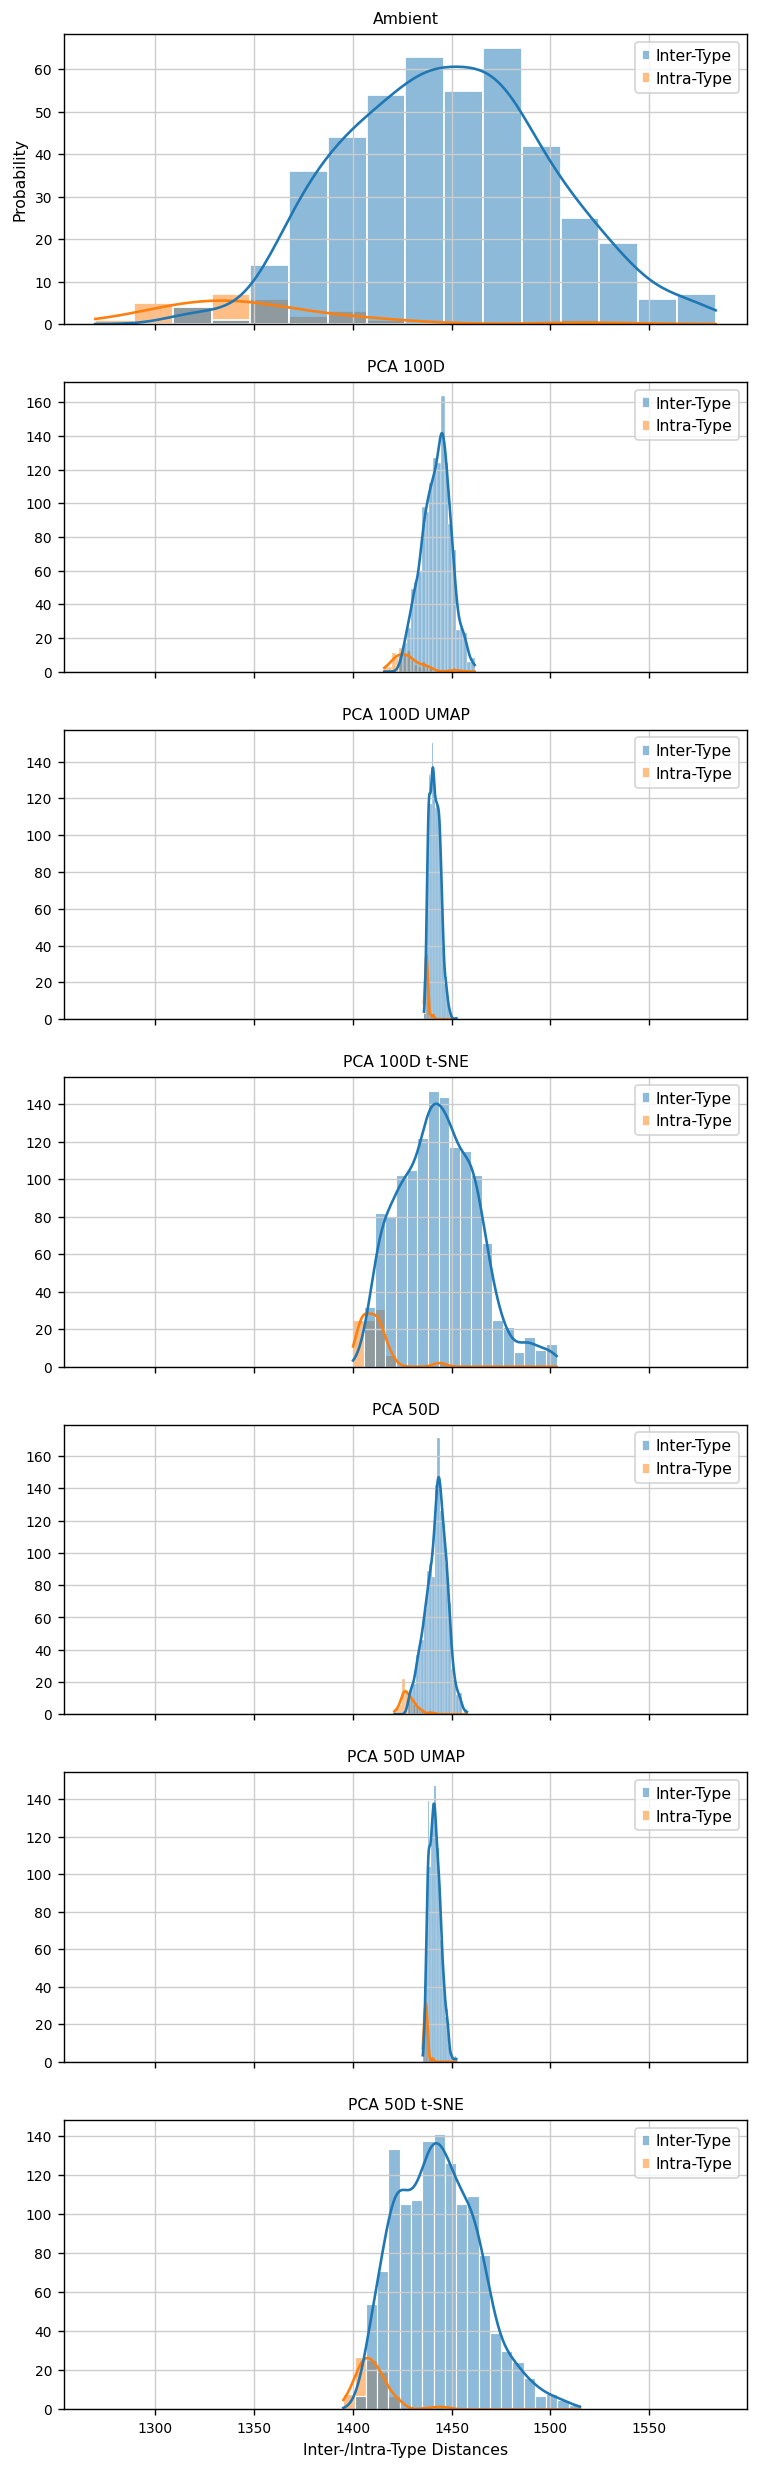

In [ ]:
plotAmb(newVals)

### **MERFISH data**

In [45]:
counts = anndata.read(data_path+'/counts.h5ad')
print(counts)

cellMeta = pd.read_csv(data_path+'/metadata.csv')
print(cellMeta.head())

AnnData object with n_obs × n_vars = 280327 × 254
     Unnamed: 0  fovID     fov_x     fov_y       volume     center_x  \
0  1.000010e+37     13  4539.310  2986.899   992.830060  4738.397298   
1  1.000020e+38    290 -4016.860  1404.780   610.091871 -3964.711404   
2  1.000070e+38    113   750.406  1143.102   148.277718   805.843523   
3  1.000070e+38    432  1262.680 -3752.030   249.515471  1348.686198   
4  1.000090e+38    354 -3627.450 -1987.730  1779.831996 -3584.650904   

      center_y         slice_id         sample_id     label     subclass  \
0  3075.327399   mouse2_slice31  dataset2_sample4   Astro_1   Astrocytes   
1  1451.889047  mouse2_slice160  dataset2_sample5      Endo  Endothelial   
2  1215.035473  mouse2_slice109  dataset2_sample6       SMC          SMC   
3 -3589.955255   mouse1_slice71  dataset1_sample2      Endo  Endothelial   
4 -1883.105955  mouse2_slice219  dataset2_sample5  L23_IT_3       L23_IT   

     class_label  
0          Other  
1          Other  
2  

In [46]:
choice = np.unique(cellMeta.slice_id)[7] #7
choice

'mouse1_slice162'

In [47]:
counts.obs['slice'] = pd.Categorical(cellMeta.slice_id)
counts.obs['type'] = pd.Categorical(cellMeta.subclass)
counts.obs['x'] = list(cellMeta.center_x)
counts.obs['y'] = list(cellMeta.center_y)

In [48]:
sub = counts[counts.obs['slice'].isin([choice])]
print(sub)

colors = np.random.rand(len(sub.obs['type']),3)
nanLabs = np.array([[np.nan]*len(sub.obs['type'])])

labs = np.array([list(sub.obs['type'])])
labs_cont = np.array([list(sub.obs['x']),list(sub.obs['y'])])

View of AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'slice', 'type', 'x', 'y'


In [49]:
orig_mat = sub.X

In [50]:
log_mat = np.log1p(sub.X)

In [51]:
sc.pp.log1p(sub)

#Center scale
sc.pp.scale(sub, max_value=10)

scaled_mat = sub.X

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [52]:
latents,latentLab,latentType = latentComp(scaled_mat, log_mat, ndims=2, pcs=[50,100], rounds = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

Check how cluster neighbor rankings are maintained

In [53]:
allNeigh = getAllNeigh(latents,latentLab,latentType,labs[0])
allNeigh.head()

Latent       Tau
0  PCA 50D  0.666667
1  PCA 50D  0.613333
2  PCA 50D  0.753333
3  PCA 50D  0.813333
4  PCA 50D  0.573333

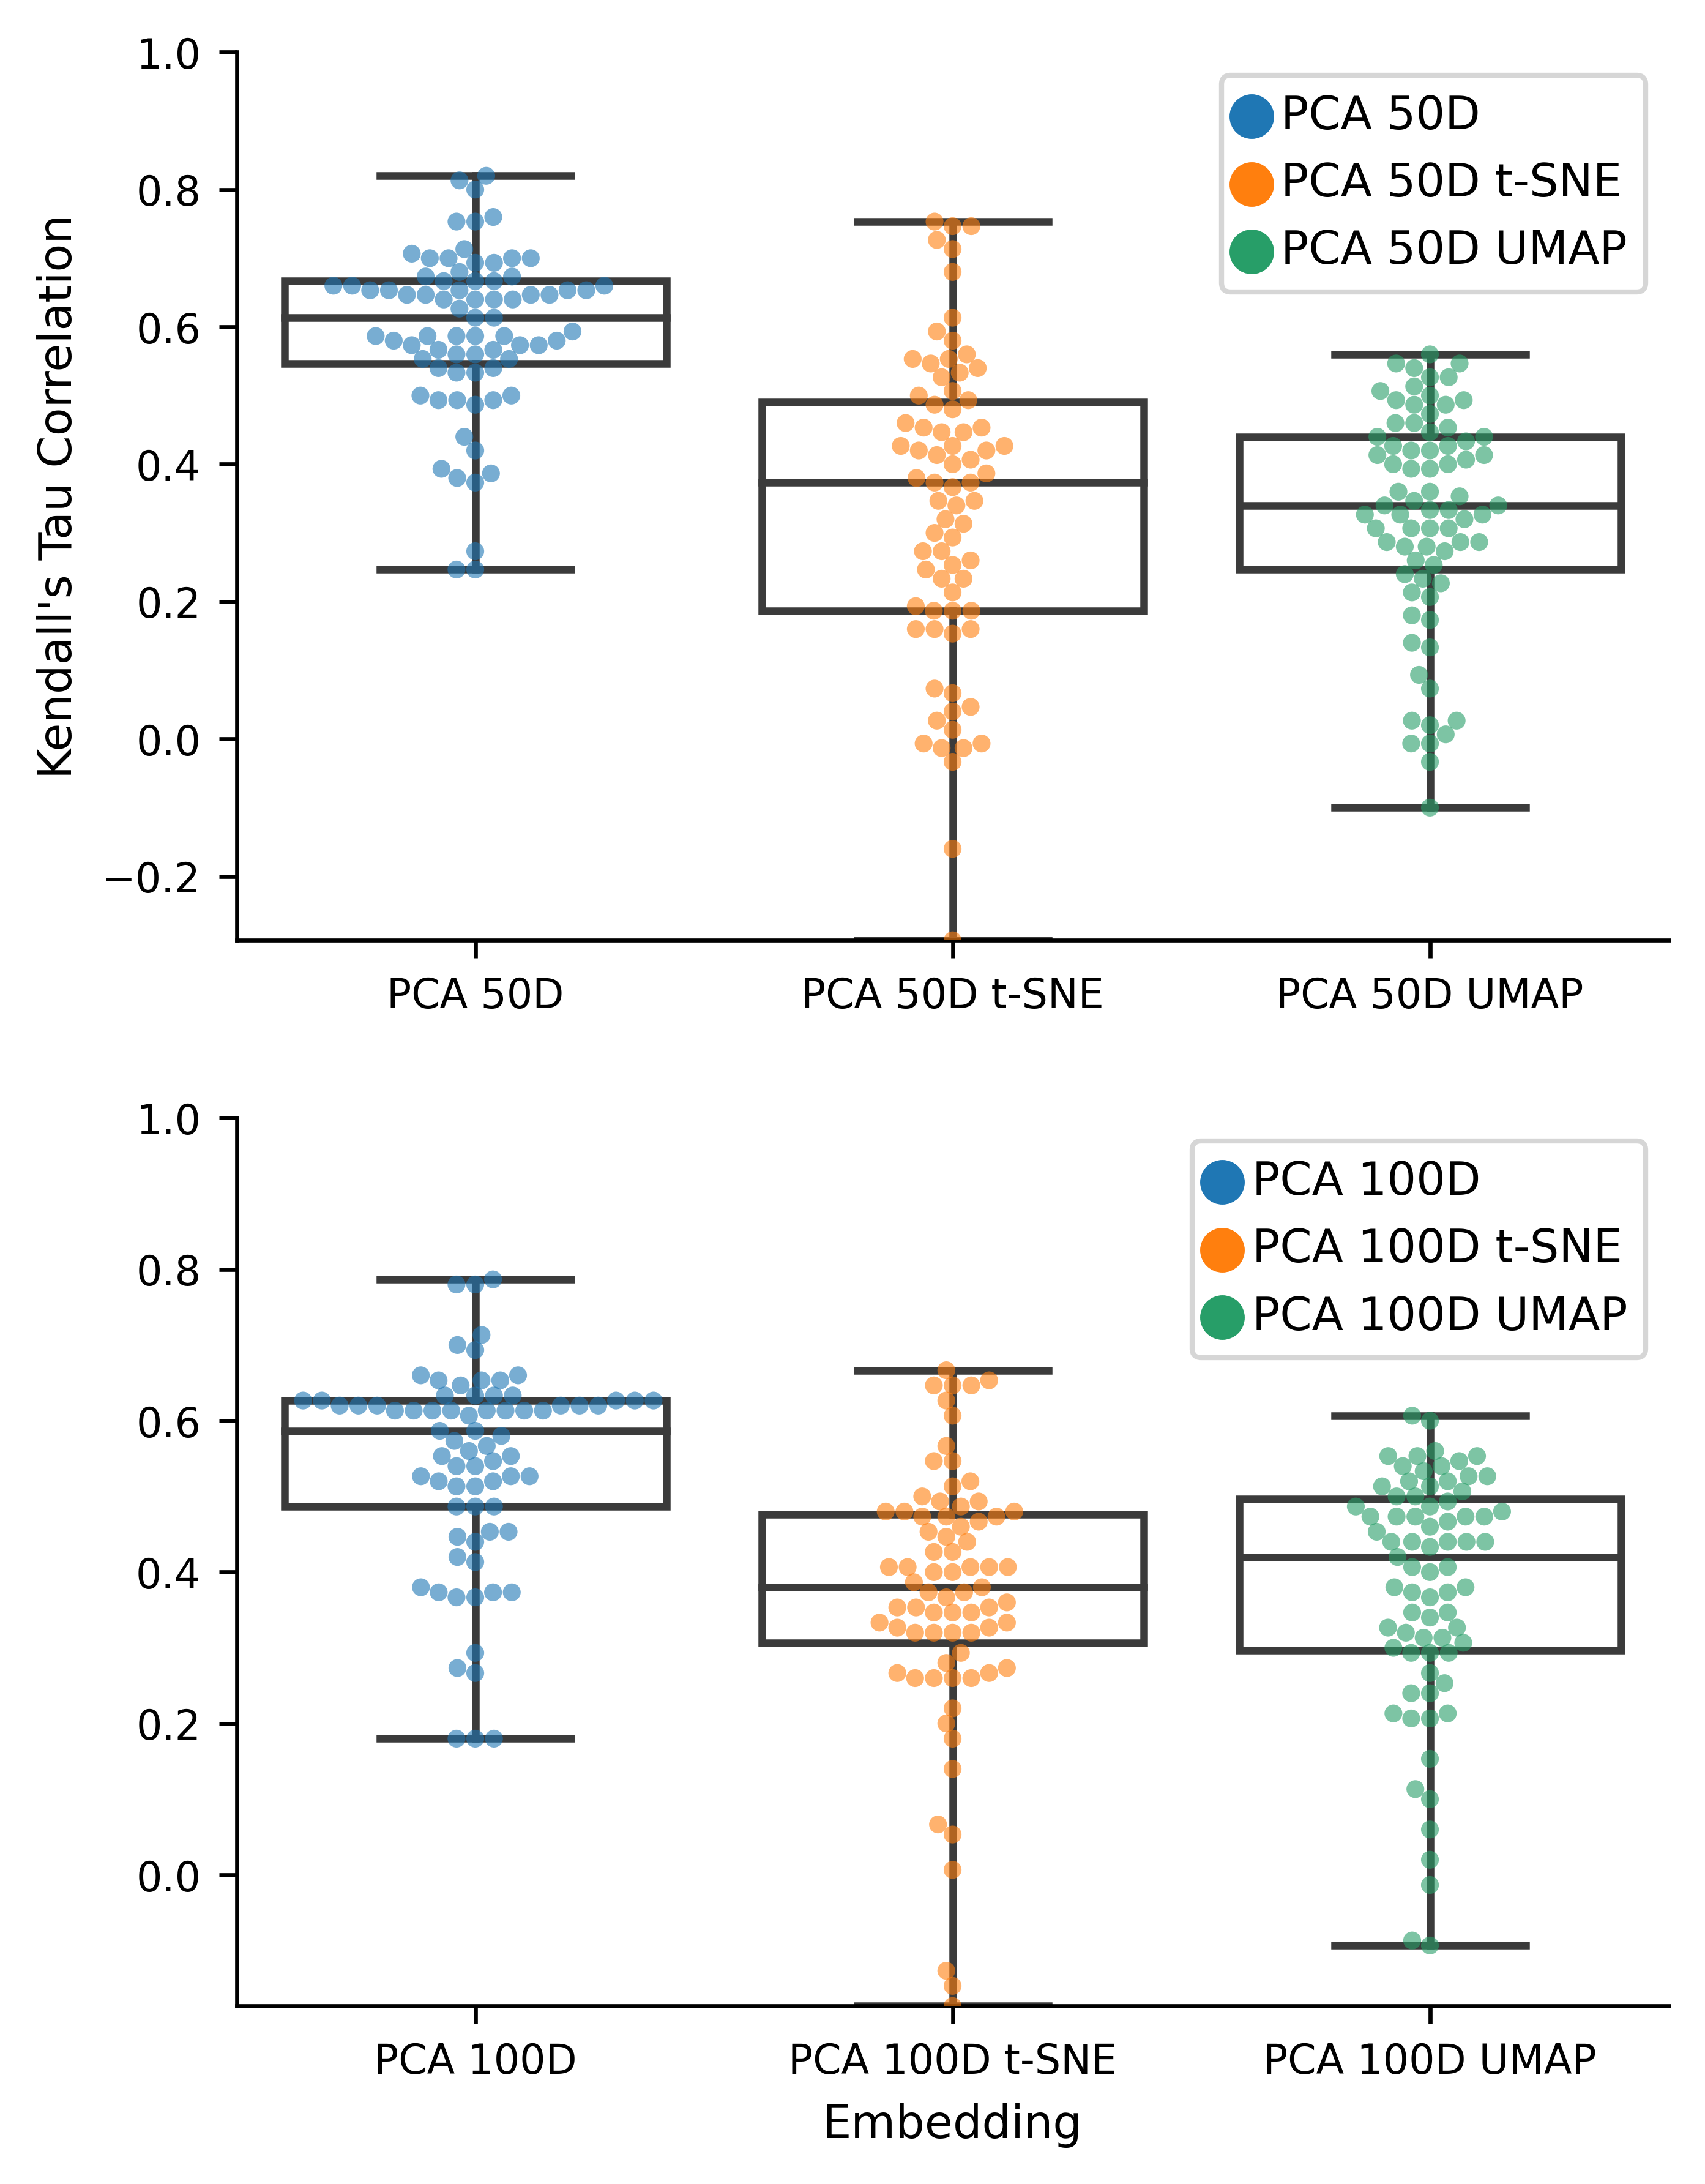

In [54]:
plotNeigh(allNeigh)

In [55]:
inds = [[1,2,3],[7,8,9],[13,14,15]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],labs[0])]
d50 = pd.concat(dfs)
d50.head()

Latent       Tau
0  PCA 50D t-SNE  0.406667
1  PCA 50D t-SNE  0.360000
2  PCA 50D t-SNE  0.453333
3  PCA 50D t-SNE  0.360000
4  PCA 50D t-SNE  0.293333

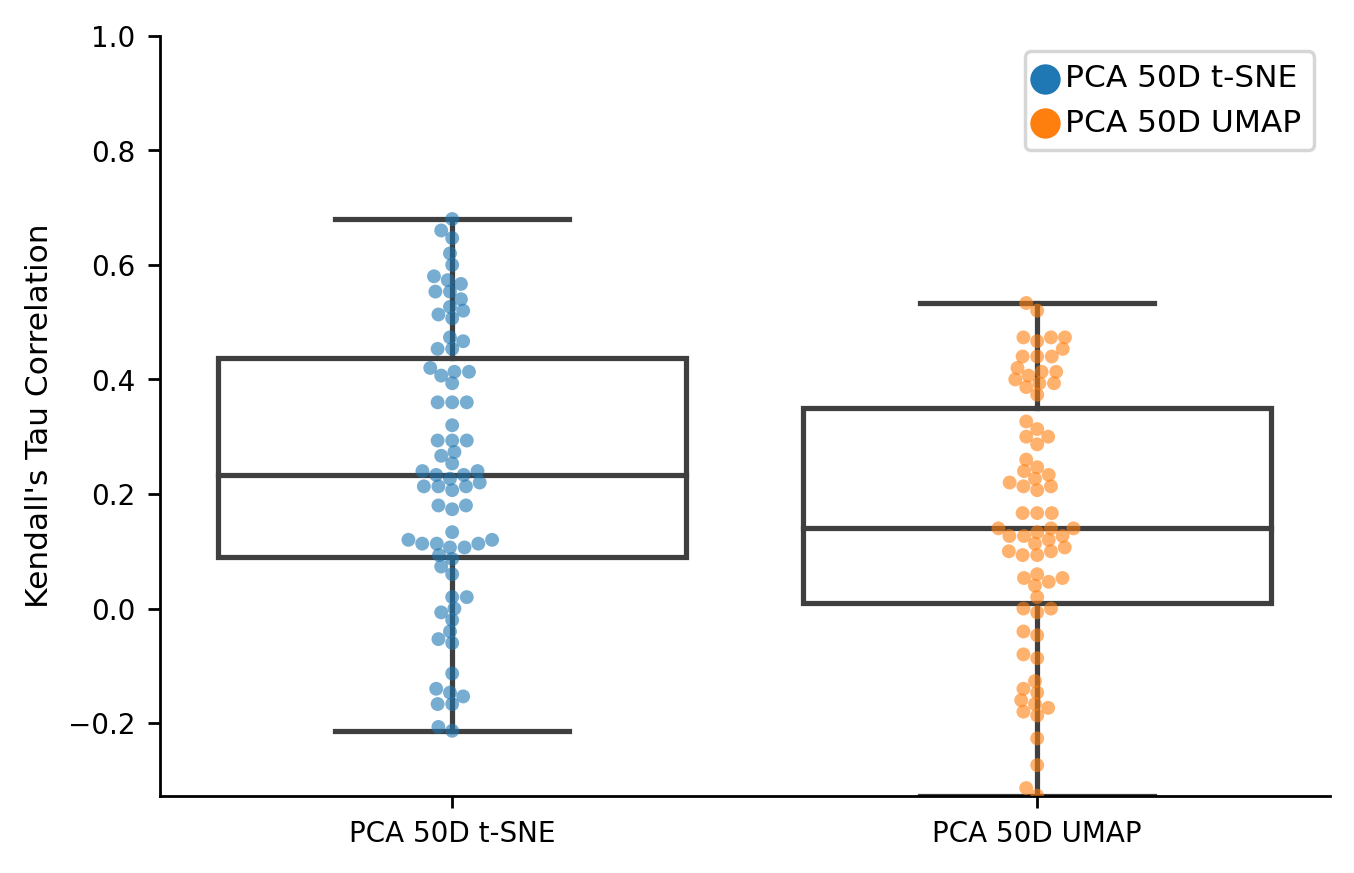

In [56]:
plotNeighSingle(d50[~d50['Latent'].isin(['PCA 50D'])],size=4,figsize=(6,4))

In [57]:
inds = [[4,5,6],[10,11,12],[16,17,18]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],labs[0])]
d100 = pd.concat(dfs)
d100.head()

Latent       Tau
0  PCA 100D t-SNE  0.226667
1  PCA 100D t-SNE  0.426667
2  PCA 100D t-SNE  0.040000
3  PCA 100D t-SNE  0.386667
4  PCA 100D t-SNE  0.473333

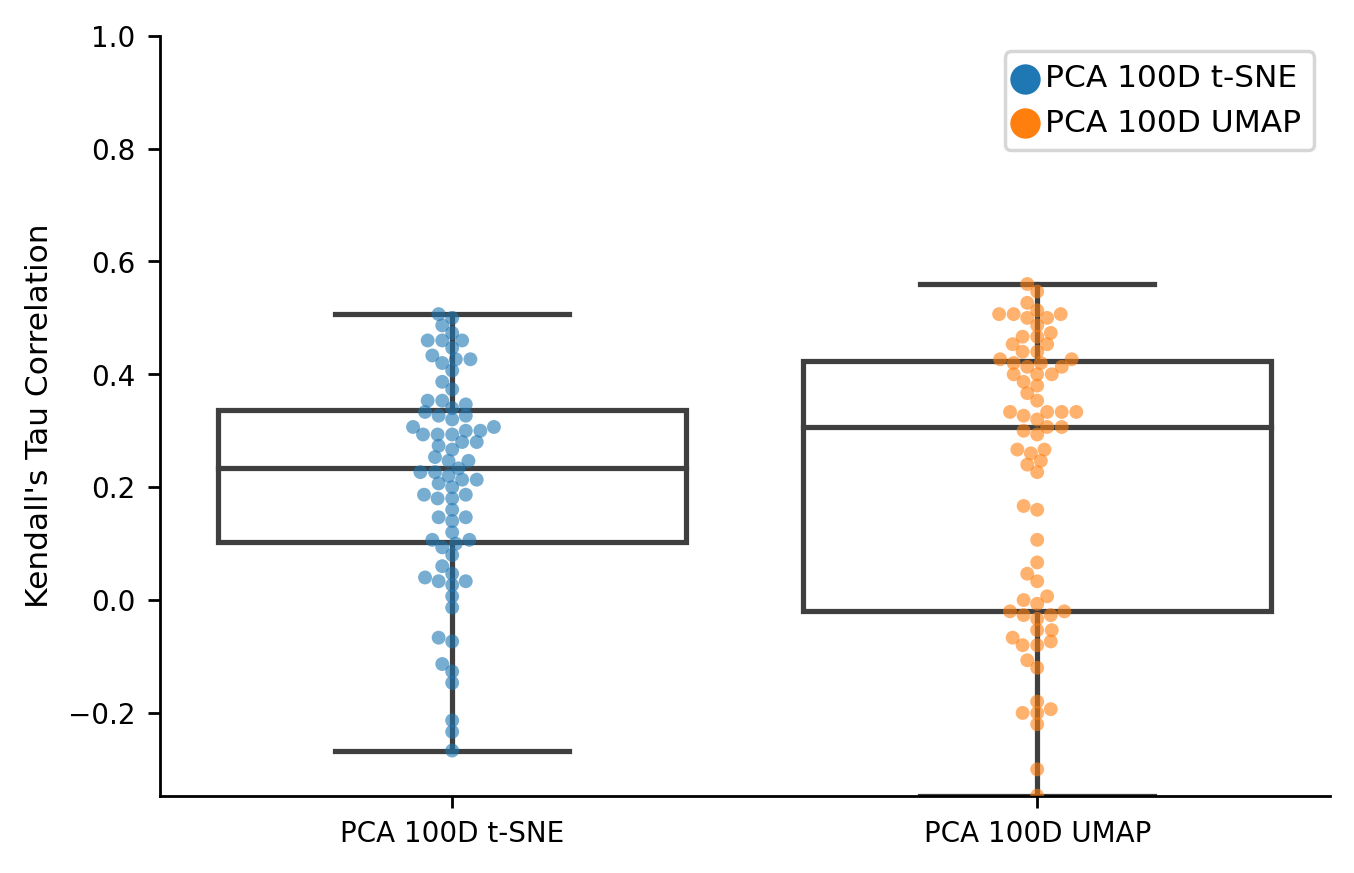

In [58]:
plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

In [ ]:
allVals = getAllVars(latents,latentLab,latentType,labs[0])
allVals.head()

In [ ]:
np.unique(allVals.Latent)

array(['Ambient', 'PCA 100D', 'PCA 100D UMAP', 'PCA 100D t-SNE',
       'PCA 50D', 'PCA 50D UMAP', 'PCA 50D t-SNE'], dtype=object)

Scale all distributions to same mean (from Ambient)

In [ ]:
test = allVals.copy()

In [ ]:
sub = test[test['Latent'].isin(['Ambient'])]
avg = np.mean(sub['Value'])

In [ ]:
np.unique(test['Latent'])

array(['Ambient', 'PCA 100D', 'PCA 100D UMAP', 'PCA 100D t-SNE',
       'PCA 50D', 'PCA 50D UMAP', 'PCA 50D t-SNE'], dtype=object)

In [ ]:
dfs = []
for i in np.unique(test['Latent']):
  sub = test[test['Latent'].isin([i])]
  sub['Value'] = sub['Value'] - np.mean(sub['Value']) + avg
  #sub['Value'][sub['Distance'].isin(['Intra-Type'])] = sub['Value'][sub['Distance'].isin(['Intra-Type'])] - np.mean(sub['Value'][sub['Distance'].isin(['Intra-Type'])]) + avg
  sub['KS'] = [stats.ks_2samp(np.array(sub['Value'][sub['Distance'].isin(['Inter-Type'])].tolist()),np.array(sub['Value'][sub['Distance'].isin(['Intra-Type'])].tolist()))]*len(sub['Value'])

 
  
  dfs += [sub]

newVals = pd.concat(dfs)

Ks_2sampResult(statistic=0.84, pvalue=0.0)
Ks_2sampResult(statistic=0.68, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.9733333333333334, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.96, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.8422222222222222, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.9644444444444444, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.96, pvalue=2.220446049250313e-16)


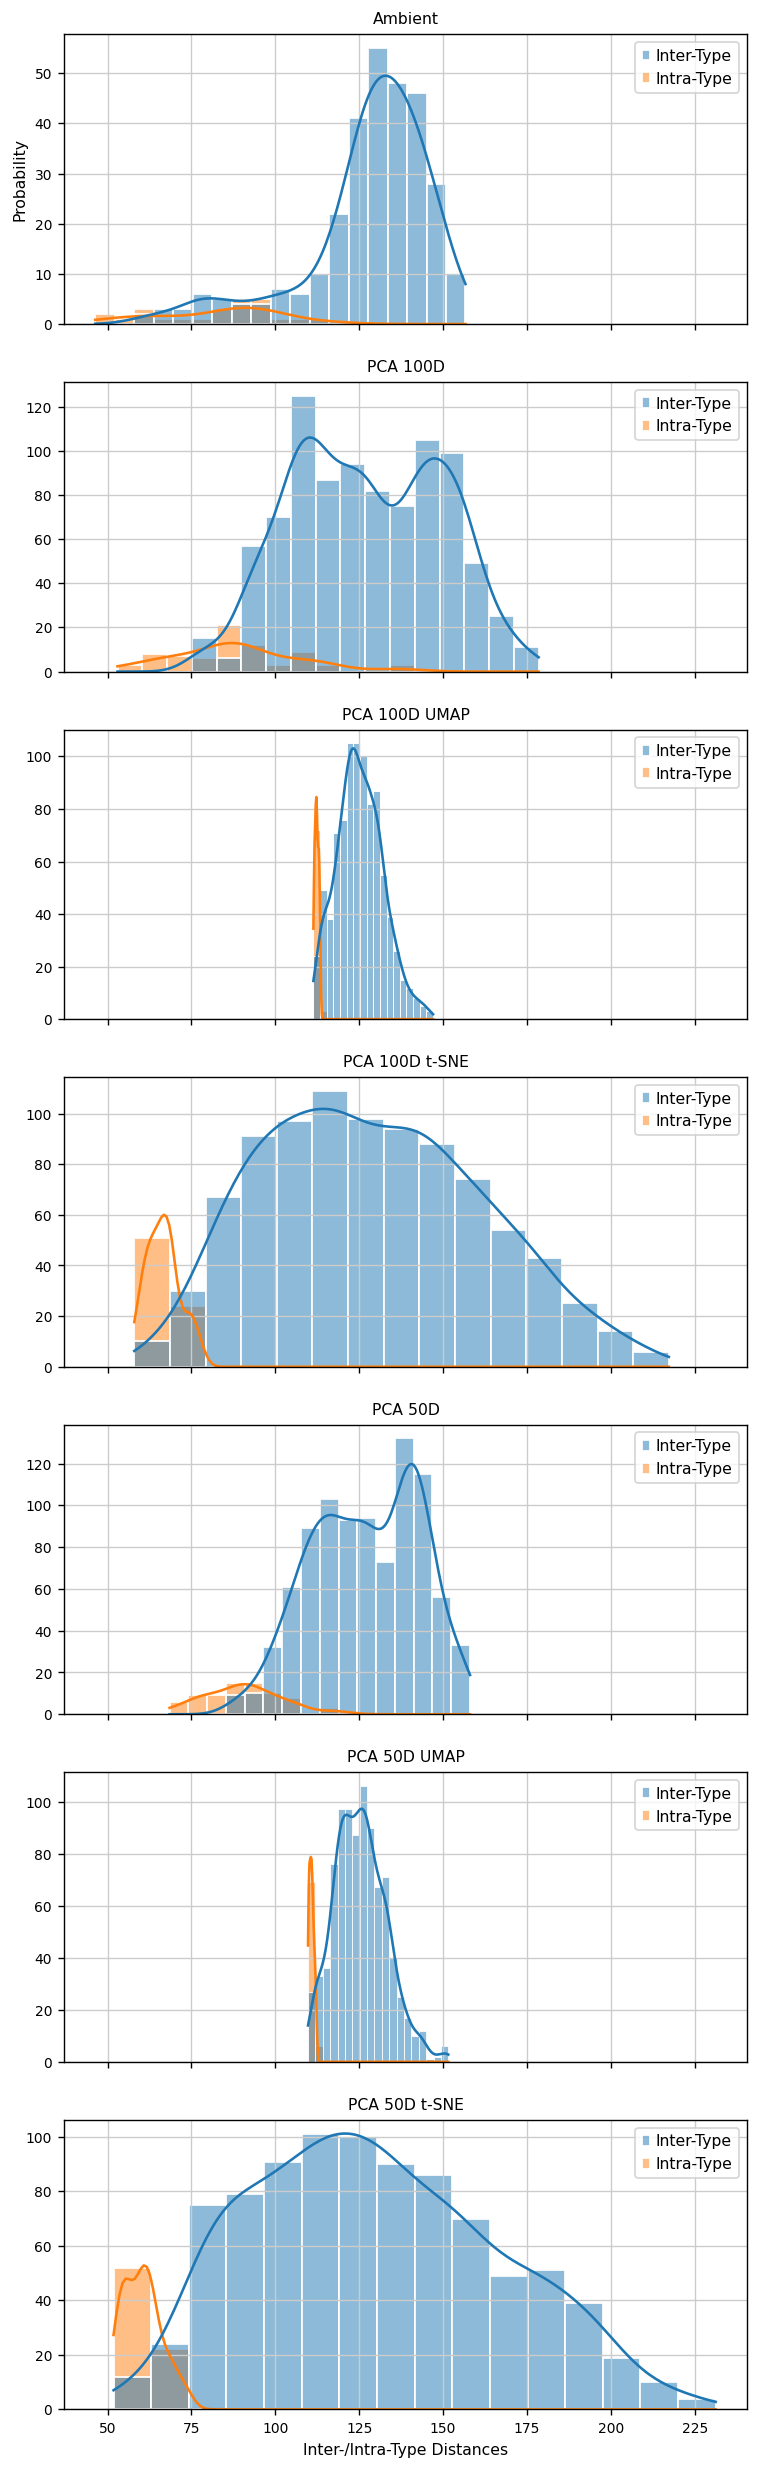

In [ ]:
plotAmb(newVals)

### **Ex Utero E8.5 data**

In [59]:
cell_types = {'0': 'Blood', '1': 'Mixed Mesoderm', '2': 'Foregut', '3': 'Cardiac', '4': 'Mid Hind Brain',
'5': 'Endothelial', '6': 'Presomitic Mesoderm', '7':'Amnion', '8':'Extra-Embryonic Endoderm', '9':'Pharyngeal Mesoderm',
'10': 'Extra-Embryonic Ectoderm', '11': 'Blood' , '12':'Placodes', '13': 'Neural Tube', '14':'Extra-Embryonic Mesoderm',
'15':'Somitic Mesoderm', '16':'Neural Crest', '17':'Amnion', '18':'Mid Hind Gut'}

#Reading in log-normalized counts only


counts = pd.read_csv(data_path+'/GSE149372_scRNA.normalized.assay85.csv',index_col=0)
print(counts.head())

cellMeta = pd.read_csv(data_path+'/GSE149372_scRNA.MetaData.85.csv')
print(cellMeta.head())

#Center and scale log-normalized data
count_mat = counts.values.T

adata = anndata.AnnData(X = count_mat)
adata.obs_names = list(counts.columns)
adata.var_names = list(counts.index)
adata.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata.obs['Cluster'] = pd.Categorical(cellMeta.seurat_clusters)
adata

exAdata = adata[adata.obs['Utero']=='ExUt']
inAdata = adata[adata.obs['Utero']=='InUt']
exAdata

#In paper, use top 2000 HVGs and 15 PCs
def scaleAdata(adata):
  sc.pp.filter_cells(adata, min_counts=0)
  sc.pp.filter_genes(adata, min_counts=0)


  sc.pp.highly_variable_genes(adata,n_top_genes=2000)

  adata = adata[:,adata.var['highly_variable']]
  adata.obsm['log'] = adata.X

  sc.pp.scale(adata, max_value=10)
  return adata

adata = scaleAdata(adata)
exAdata = scaleAdata(exAdata)
inAdata = scaleAdata(inAdata)

toUseAdata = exAdata
count_mat = toUseAdata.obsm['log']
scaled_mat = toUseAdata.X

#Set colors for cell clusters
colors = np.random.rand(len(toUseAdata.obs['Cluster']),3)

labs = np.array([list(toUseAdata.obs['Cluster']),list(toUseAdata.obs['Utero'])])

# adata.obs['Cluster'].value_counts()
#

        AAACGAAAGTCCCGAC-1  AAACGAAGTCGAGTTT-1  AAACGCTAGGACTTCT-1  \
Xkr4              0.000000            0.000000            0.000000   
Rp1               0.000000            0.000000            0.597661   
Sox17             0.000000            0.000000            0.000000   
Mrpl15            1.175618            0.559627            0.597661   
Lypla1            0.751450            0.916306            0.597661   

        AAACGCTCAACGCCCA-1  AAACGCTTCTGTGCGG-1  AAACGCTTCTTCTAAC-1  \
Xkr4                   0.0            0.000000            0.000000   
Rp1                    0.0            0.000000            0.000000   
Sox17                  0.0            0.000000            0.000000   
Mrpl15                 0.0            1.487989            0.770525   
Lypla1                 0.0            0.000000            0.000000   

        AAAGAACGTCTACACA-1  AAAGAACTCGACGACC-1  AAAGGATCAGTTCTAG-1  \
Xkr4                   0.0                 0.0            0.000000   
Rp1               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:128: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if min_genes is None and max_genes is None: adata.obs['n_counts'] = number


In [60]:
latents,latentLab,latentType = latentComp(scaled_mat, count_mat, ndims=2, pcs=[50,100], rounds = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

Check ranking of cluster neighbors

In [61]:
allNeigh = getAllNeigh(latents,latentLab,latentType,labs[0])
allNeigh.head()

Latent       Tau
0  PCA 50D  0.859649
1  PCA 50D  0.871345
2  PCA 50D  0.789474
3  PCA 50D  0.871345
4  PCA 50D  0.883041

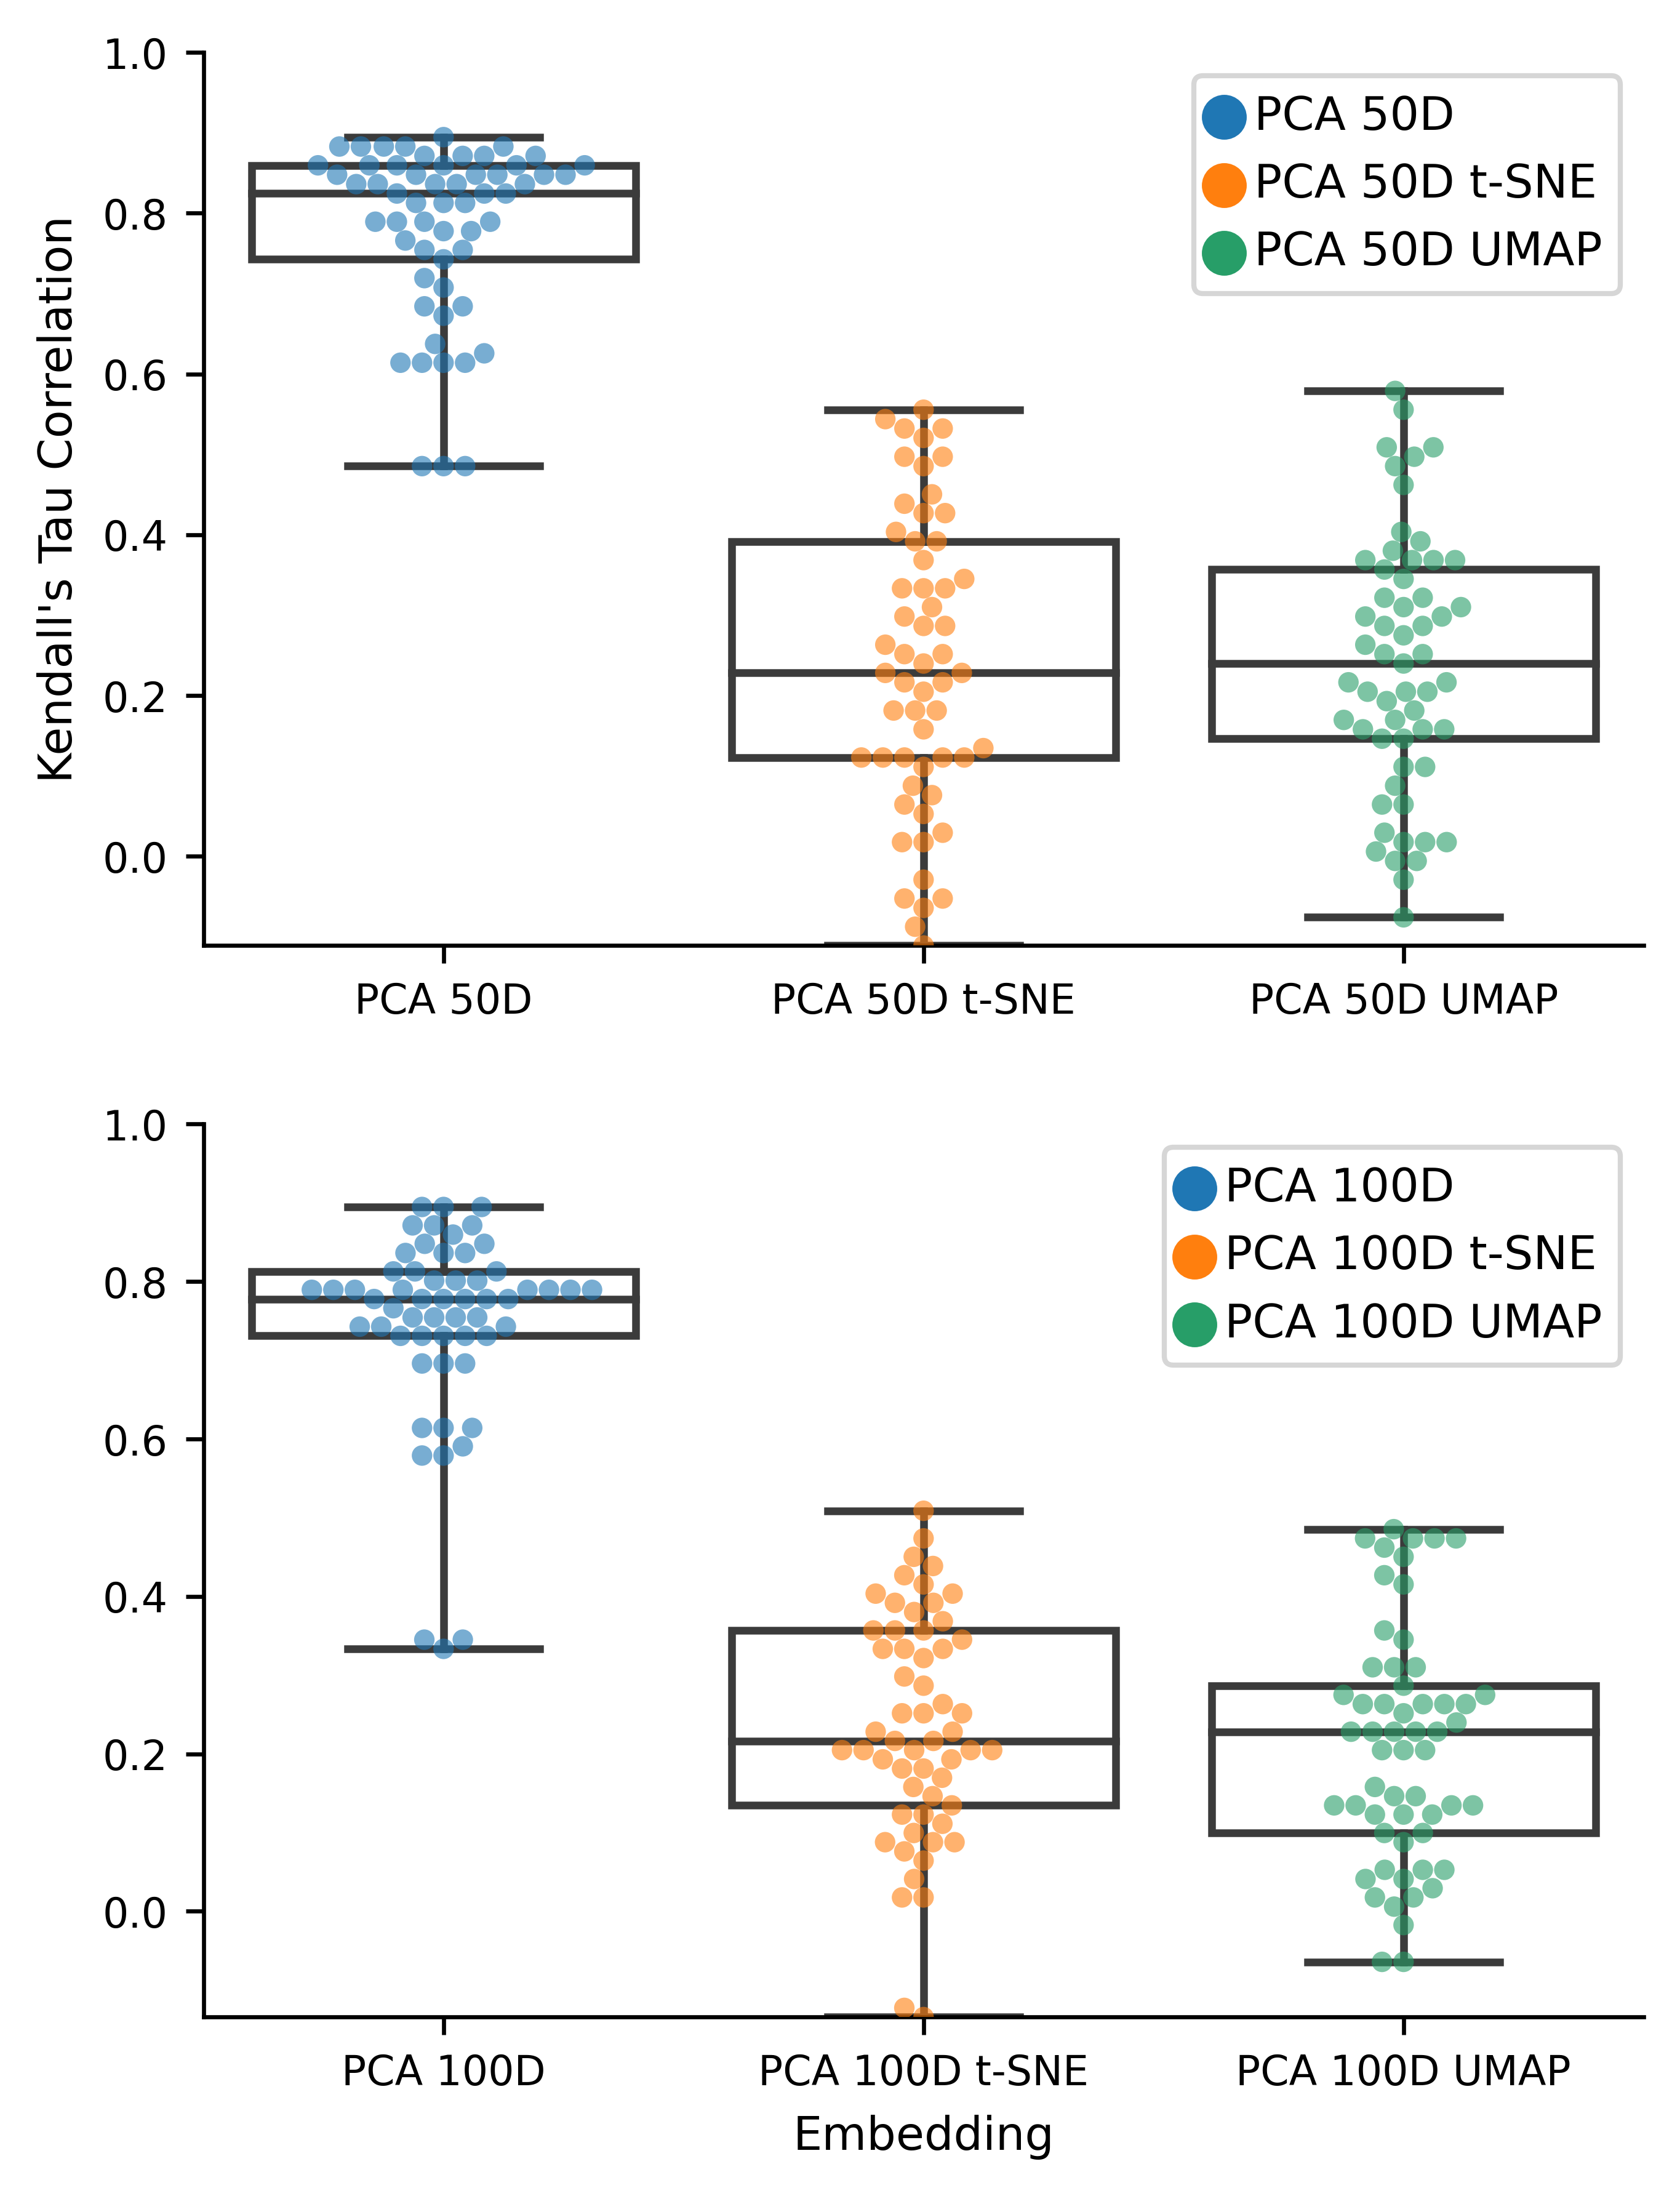

In [62]:
plotNeigh(allNeigh,size=4)

In [63]:
inds = [[1,2,3],[7,8,9],[13,14,15]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],labs[0])]
d50 = pd.concat(dfs)
d50.head()

Latent       Tau
0  PCA 50D t-SNE  0.216374
1  PCA 50D t-SNE  0.415205
2  PCA 50D t-SNE  0.508772
3  PCA 50D t-SNE  0.064327
4  PCA 50D t-SNE  0.134503

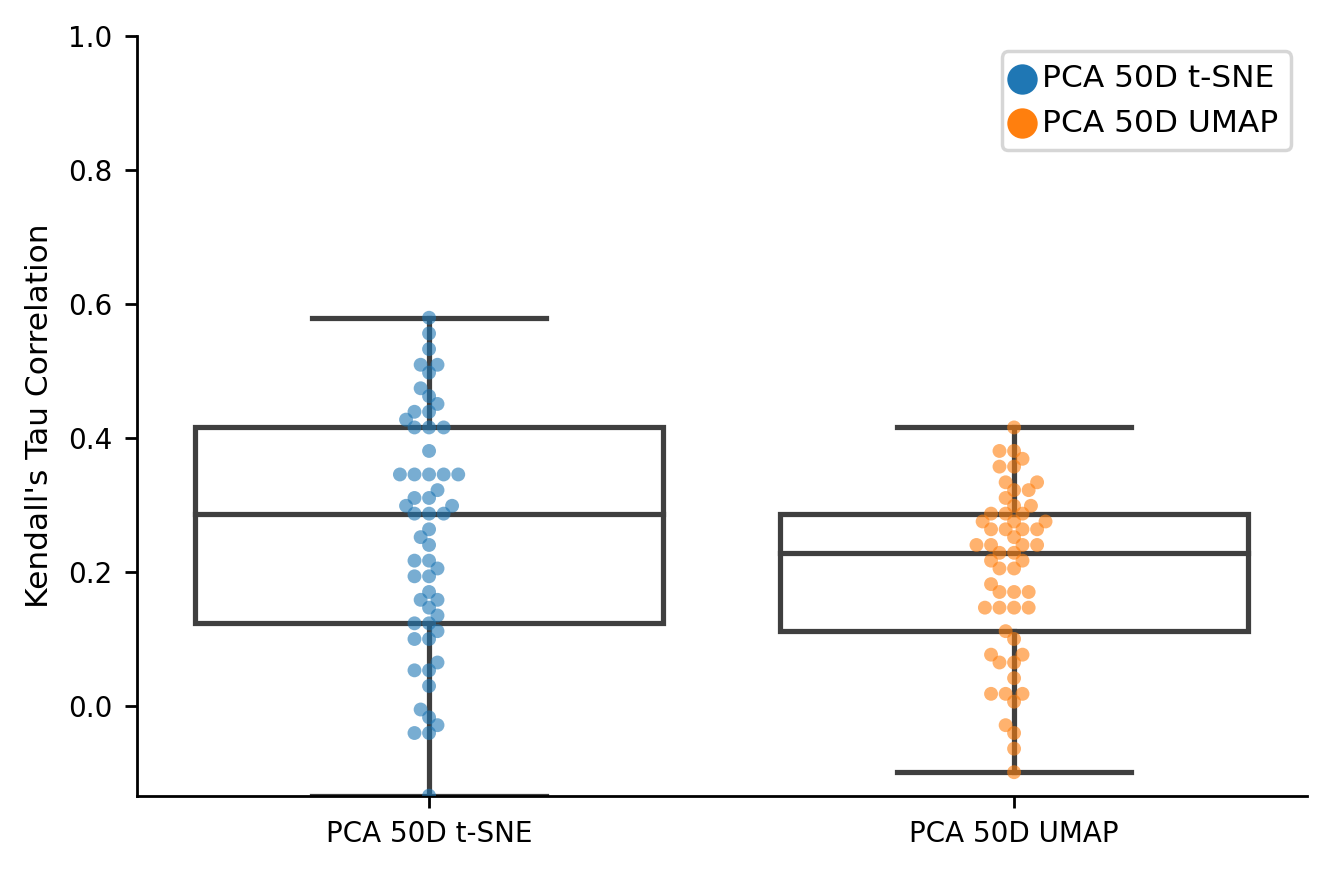

In [64]:
plotNeighSingle(d50[~d50['Latent'].isin(['PCA 50D'])],size=4,figsize=(6,4))

In [65]:
inds = [[4,5,6,],[10,11,12],[16,17,18]]
dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],labs[0])]
d100 = pd.concat(dfs)
d100.head()

Latent       Tau
0  PCA 100D t-SNE -0.017544
1  PCA 100D t-SNE  0.146199
2  PCA 100D t-SNE  0.216374
3  PCA 100D t-SNE  0.239766
4  PCA 100D t-SNE  0.309942

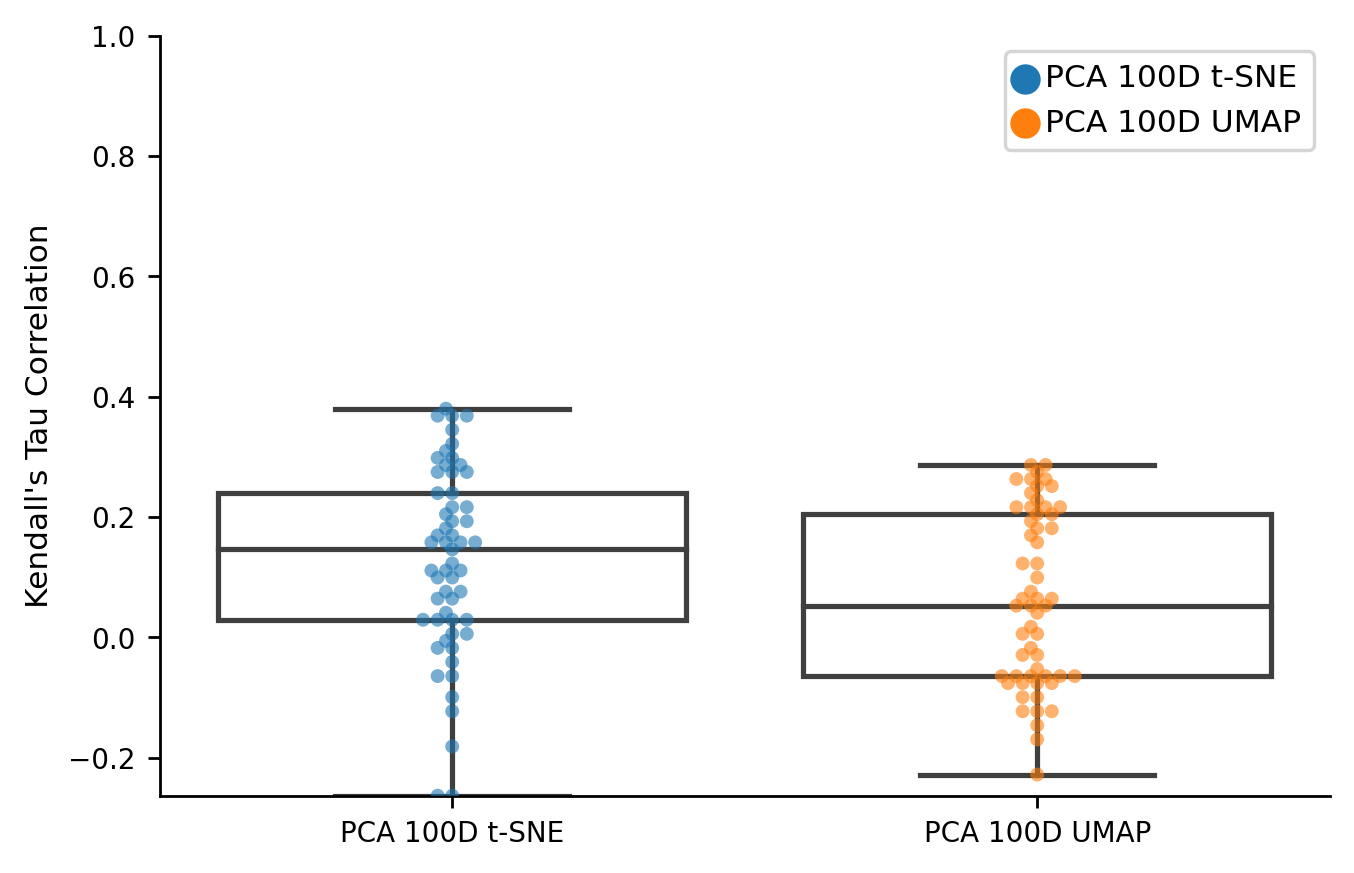

In [66]:
plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

In [ ]:
allVals = getAllVars(latents,latentLab,latentType,labs[0])
allVals.head()

Latent    Distance       Value
0  Ambient  Inter-Type  198.212036
1  Ambient  Inter-Type  229.113797
2  Ambient  Inter-Type  139.893325
3  Ambient  Inter-Type  244.803672
4  Ambient  Inter-Type  203.088811

Scale all distributions to same mean (from Ambient)

In [ ]:
test = allVals.copy()

In [ ]:
sub = test[test['Latent'].isin(['Ambient'])]
avg = np.mean(sub['Value'])

In [ ]:
dfs = []
for i in np.unique(test['Latent']):
  sub = test[test['Latent'].isin([i])]
  sub['Value'] = sub['Value'] - np.mean(sub['Value']) + avg
  #sub['Value'][sub['Distance'].isin(['Intra-Type'])] = sub['Value'][sub['Distance'].isin(['Intra-Type'])] - np.mean(sub['Value'][sub['Distance'].isin(['Intra-Type'])]) + avg
  sub['KS'] = [stats.ks_2samp(np.array(sub['Value'][sub['Distance'].isin(['Inter-Type'])].tolist()),np.array(sub['Value'][sub['Distance'].isin(['Intra-Type'])].tolist()))]*len(sub['Value'])

  
  dfs += [sub]

newVals = pd.concat(dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Ks_2sampResult(statistic=0.43859649122807015, pvalue=0.0018109152185037392)
Ks_2sampResult(statistic=0.48927875243664715, pvalue=9.587441951453002e-12)
Ks_2sampResult(statistic=0.8440545808966862, pvalue=3.5993146441616727e-32)
Ks_2sampResult(statistic=0.9005847953216374, pvalue=1.450887503578062e-36)
Ks_2sampResult(statistic=0.6042884990253411, pvalue=1.071030992433716e-16)
Ks_2sampResult(statistic=0.884990253411306, pvalue=2.52568023287664e-35)
Ks_2sampResult(statistic=0.9044834307992202, pvalue=7.047924971184153e-37)


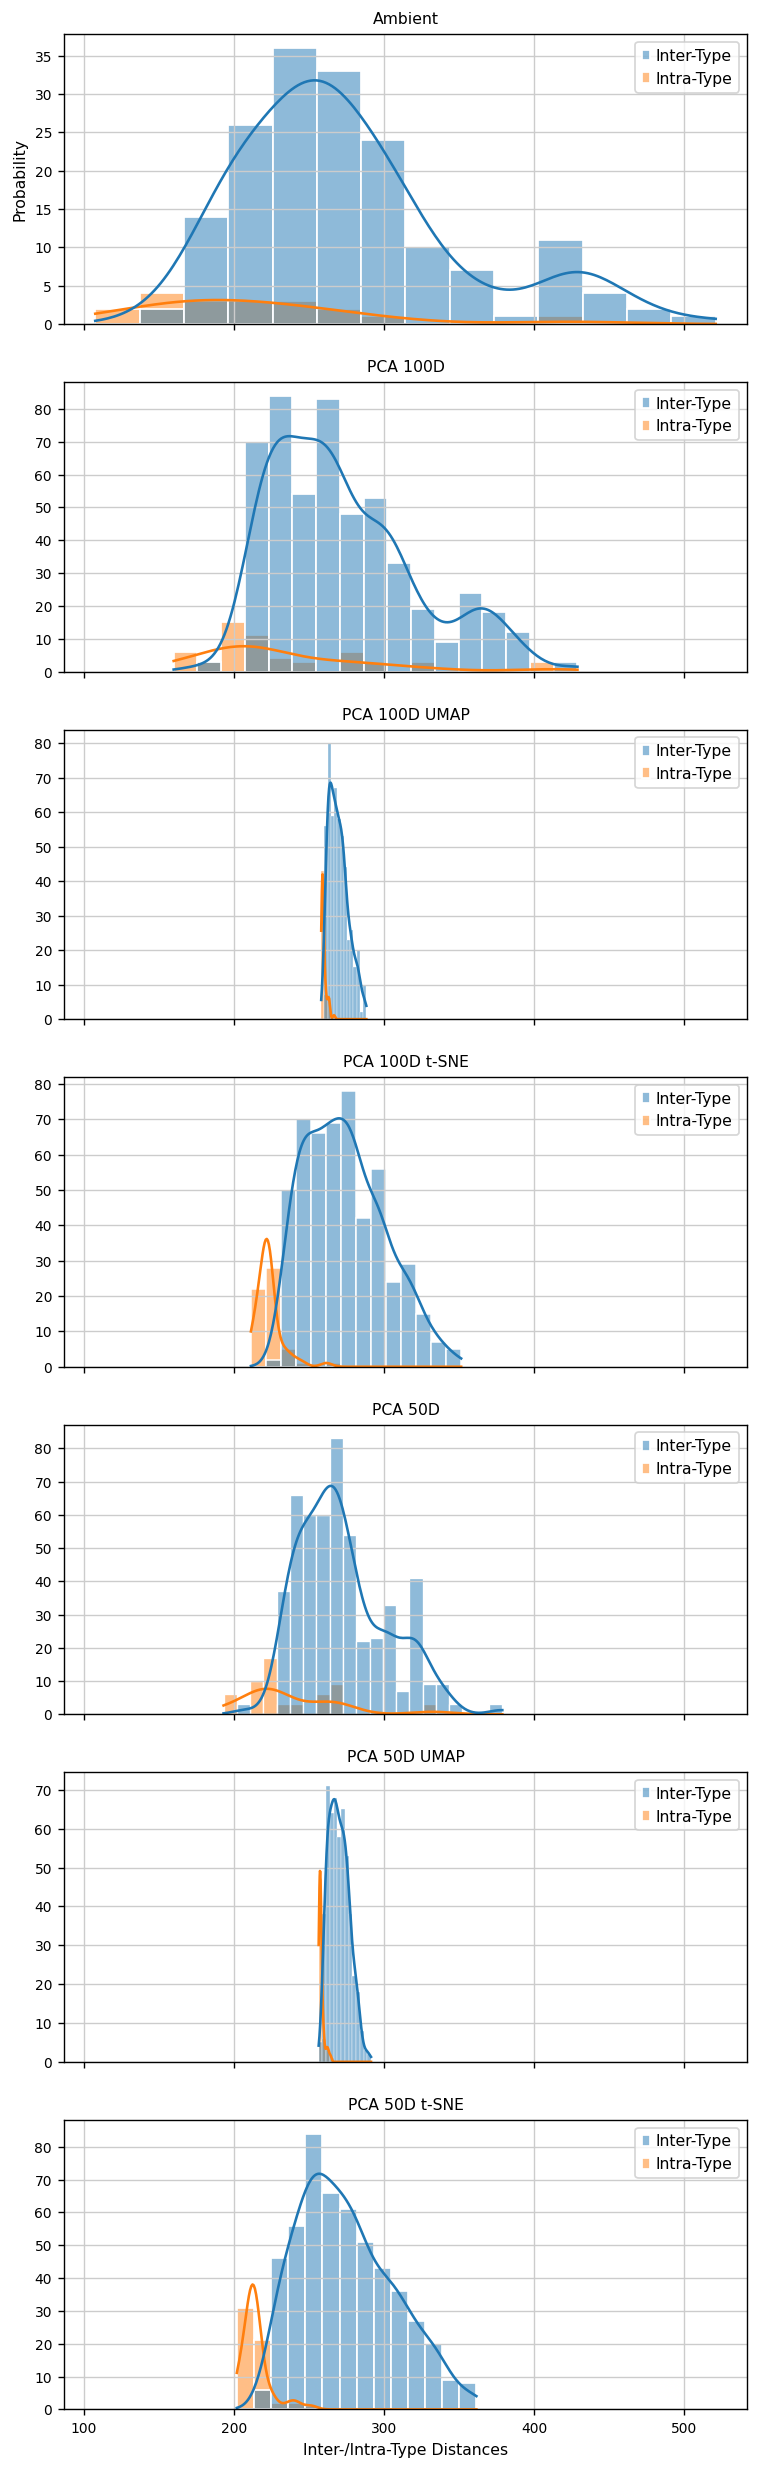

In [ ]:
plotAmb(newVals)